In [1]:
# Standard library imports
import numpy as np
import torch
import warnings

# First-party imports
import sys, os
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
sys.path.append(os.path.expanduser('~/Seacast'))
from src.seacast_tools.scoring_analysis import *

# Third-party imports
from tqdm.notebook import tqdm
# Set up session settings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# mesh_coords_utils.py
# --------------------
# Module to define classes and functions for handling 
# mesh levels and converting relative mesh coordinates 
# to geographical coordinates.

from dataclasses import dataclass, field
import os
import torch

@dataclass
class MeshLevels:
    """Class to handle mesh levels and feature directory paths."""
    exp_name: str
    _feat_dir_cache: str = field(repr=False)
    features_filename: str
    _levels_cache: torch.Tensor = field(default=None, init=False, repr=False)

    @property
    def levels(self) -> torch.Tensor:
        """Load and cache mesh levels from the feature directory."""
        if self._levels_cache is None:
            self._levels_cache = torch.load(self.feat_dir)
        return self._levels_cache
    @property
    def feat_dir(self) -> str:
        """Construct and cache the feature directory path."""
        parent_dir = os.path.dirname(os.path.normpath(self._feat_dir_cache))
        self._feat_dir_cache = os.path.join(parent_dir, self.features_filename)
        return self._feat_dir_cache 

@dataclass
class CoordGrid:
    """Class to load latitude and longitude grid from experiment data."""
    _experiment: StatsLoader = field(repr=False)
    lon: torch.Tensor = field(init=False)
    lat: torch.Tensor = field(init=False)
    def __post_init__(self):
        self.lon, self.lat = self._get_lat_lon_grid(self._experiment)

    def _get_lat_lon_grid(self, exp: StatsLoader):
        """Get latitude and longitude grid from the experiment data."""
        score = 'SquaredError'
        var_name = 'sst_temperature'
        with StatsAggSession(exp) as stats:
            data = stats.agg_scores([])[score][var_name].squeeze()
            lon = data.longitude.data
            lat = data.latitude.data
        return lon, lat

class CoordMeshExp:
    """Class to convert relative mesh coordinates to geographical coordinates."""
    def __init__(
            self, 
            experiment: StatsLoader, 
            coord_grid: CoordGrid, 
            mesh_levels: MeshLevels
            ):
        self.experiment = experiment.name
        self.levels = mesh_levels.levels
        self.grid_lon, self.grid_lat = coord_grid.lon, coord_grid.lat
        self.lon, self.lat = self._relative_coords_to_geocoords(experiment)
    
    def __repr__(self):
        return f"CoordMeshExp(exp_name={self.experiment}, n_levels={len(self.levels)}, n_lon={len(self.lon_data)}, n_lat={len(self.lat_data)})"
    
    def _relative_coords_to_geocoords(self, experiment: StatsLoader):
        """Convert relative coordinates in L1 to geographical coordinates using lon_data and lat_data."""
        L1 = self.levels[0]
        assert L1.dim() == 2, "Input tensor must be 2-dimensional"
        return (
            [self.grid_lon[idx-1].item() for idx in (len(self.grid_lon) * L1[:, 0].numpy()).astype(int)],
            [self.grid_lat[idx-1].item() for idx in (len(self.grid_lat) * L1[:, 1].numpy()).astype(int)]
            )

In [14]:
# k_domain_utils.py
# --------------------
# Module to define classes and functions for handling
# k-nearest neighbors search in the mesh domain.

from scipy.spatial import KDTree
from itertools import product
from collections import defaultdict
from enum import Enum

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

@dataclass
class CellPoint:
    lon: float
    lat: float
    value: float | np.ndarray= None
    area_km: float = field(default_factory=float, init=False, repr=True)
    resolution: float = 0.05 # degrees
    
    def __iter__(self):
        yield self.lon
        yield self.lat

    def __post_init__(self):
        self.area_km = self.get_point_area()

    def get_point_area(self) -> float:
        """Calculate the area represented by a CellPoint based on its latitude."""
        height_km = 111 * self.resolution  # Approx height in km
        width_km = 111 * np.cos(np.radians(self.lat)) * self.resolution  # Approx width in km^2
        return float(height_km * width_km)

@dataclass
class TesselaValues:
    grid_knn: List[CellPoint]
    mean_rmse_by_leadtime: List[float] = field(default_factory=list, init=False, repr=False)
    std_rmse_by_leadtime: List[float] = field(default_factory=list, init=False, repr=False)
    slope_rmse: float = field(default_factory=float, init=False, repr=False)
    area: float = field(default_factory=float, init=False, repr=True)

def get_k_domain(
        mesh_coords: Tuple[List[float], List[float]], 
        grid_coords: CoordGrid,
        k: int
        ) -> Dict[Tuple[int], List[List[float]]]:
    mesh_nodes = np.array(mesh_coords).T
    tree = KDTree(mesh_nodes)
    # Punto de consulta
    d_knn = defaultdict(list)
    for (lon, lat) in product(grid_coords.lon, grid_coords.lat):
        p = CellPoint(lon=float(lon), lat=float(lat))
        # Buscar el vecino más cercano
        _, idx = tree.query((p.lon, p.lat), k=k)  # k más cercano
        key = tuple(set(idx.tolist()) if idx.size > 1 else set([idx.item()]))
        d_knn[key].append(p)
        
    NTessela = Enum("NTessela", {f"cell{k}": k for k in d_knn.keys()})
    d_knn = {NTessela[f'cell{k}']: TesselaValues(grid_knn=v) for k, v in d_knn.items()}

    return d_knn

def not_empty_check(p: CellPoint) -> bool:
    """Check if a CellPoint is not in the empty points set."""
    return not np.isnan(p.value).all()

def _remove_outliers(areas: list, rmse: list) -> List[tuple]:
    """Remove outliers from a list of numerical data using the IQR method."""

    Q1 = np.percentile(rmse, 25)
    Q3 = np.percentile(rmse, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return [(area, err) for (area, err) in zip(areas, rmse) if lower_bound <= err <= upper_bound]

In [11]:
def get_slope(lead_day_scores):
    X = np.arange(len(lead_day_scores)).reshape(-1,1)
    y = np.array(lead_day_scores)
    model = LinearRegression().fit(X, y)
    return model.coef_[0]  # Pendiente de la serie completa

## Structured mesh: U-mesh
---

In [4]:
%%time
# number of nodes sequence for unstructured and structured meshes
structured_nodes = ["5_4", "6_4", "8_6", "10_7", "17_12"]
# mesh file names sequences
non_crossing_mesh_names = [f"non_crossing_edges_m_{node}_g2mm2g_4" for node in structured_nodes]
# all experiment names
experiments_names =  non_crossing_mesh_names
    
# load all experiments
experiments = [
    StatsLoader(os.path.join("~/Seacast/output/increase_n_nodes", exp_name)) 
    for exp_name in experiments_names
    ]

experiments = [
    StatsLoader(os.path.join("~/Seacast/output/increase_n_nodes", exp_name)) 
    for exp_name in experiments_names
    ]
experiments

CPU times: user 85 μs, sys: 0 ns, total: 85 μs
Wall time: 91.8 μs


[ExpStats(name=non_crossing_edges_m_5_4_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/non_crossing_edges_m_5_4_g2mm2g_4/statistics),
 ExpStats(name=non_crossing_edges_m_6_4_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/non_crossing_edges_m_6_4_g2mm2g_4/statistics),
 ExpStats(name=non_crossing_edges_m_8_6_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/non_crossing_edges_m_8_6_g2mm2g_4/statistics),
 ExpStats(name=non_crossing_edges_m_10_7_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/non_crossing_edges_m_10_7_g2mm2g_4/statistics),
 ExpStats(name=non_crossing_edges_m_17_12_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/non_crossing_edges_m_17_12_g2mm2g_4/statistics)]

In [5]:
%%time
# Get mesh coordinates for each experiment
mesh_coords = {}
for exp in experiments:
    mesh_levels = MeshLevels(
        exp.name, 
        exp.stats_dir, 
        'mesh_features.pt'
        )
    coords_grid = CoordGrid(exp)
    coords_mesh_exp = CoordMeshExp(exp, coords_grid, mesh_levels)
    mesh_coords[exp.name] = (coords_mesh_exp.lon, coords_mesh_exp.lat)

KeyboardInterrupt: 

In [ ]:
k_voronoi_tesela_maps = {}
for exp in experiments:
    mesh_nodes = mesh_coords[exp.name]
    k_voronoi_tesela_maps[exp.name] = get_k_domain(
        mesh_coords=(mesh_nodes[0], mesh_nodes[1]), 
        grid_coords=coords_grid,
        k=int(exp.name[-1])
        )

In [ ]:
score = 'SquaredError'
var_name = 'sst_temperature'

for exp in tqdm(experiments): 
    with StatsAggSession(exp) as stats:
        data = stats.agg_scores(
            ['init_time']
            )[score][var_name].squeeze()

    tesela_map = k_voronoi_tesela_maps[exp.name]
    # Assign RMSE values to each cell point
    for tessela in tesela_map.values():
        # Create a checker for empty points
        for p in tessela.grid_knn:
            rmse_by_cell = data.sel(
                longitude=p.lon, latitude=p.lat
                )

            n_leads = rmse_by_cell.lead_time.size
            p.value = rmse_by_cell.data
        # Filter out empty points (tesselas partially over land)
        tessela.grid_knn = list(filter(not_empty_check, tessela.grid_knn))
        # Skip tesselas with no valid points (over land)
        if len(tessela.grid_knn) == 0:
            continue

        # Compute mean and std dev for each tessela    
        rmse_by_point = np.array([p.value for p in tessela.grid_knn])
        tessela.area = sum([p.area_km for p in tessela.grid_knn]) # km^2
        rmse_mean_by_tessela = np.nanmean(rmse_by_point, axis=0)
        rmse_std_by_tessela = np.nanstd(rmse_by_point, axis=0)

        # filter_nan_means = _remove_nans(rmse_mean_by_tessela)
        # filter_nan_stds = _remove_nans(rmse_std_by_tessela)
        if len(rmse_mean_by_tessela) != 0:
            tessela.mean_rmse = rmse_mean_by_tessela
            tessela.slope = get_slope(rmse_mean_by_tessela)
            tessela.std_rmse = rmse_std_by_tessela
        else:
            tessela.mean_rmse = np.repeat(np.nan, n_leads)
            tessela.slope = np.nan
            tessela.std_rmse = np.repeat(np.nan, n_leads)
    # Filter out tesselas with no valid points (over land)
    tesela_map = dict(filter(lambda item: len(item[1].grid_knn) > 0, tesela_map.items()))
    k_voronoi_tesela_maps[exp.name] = tesela_map

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

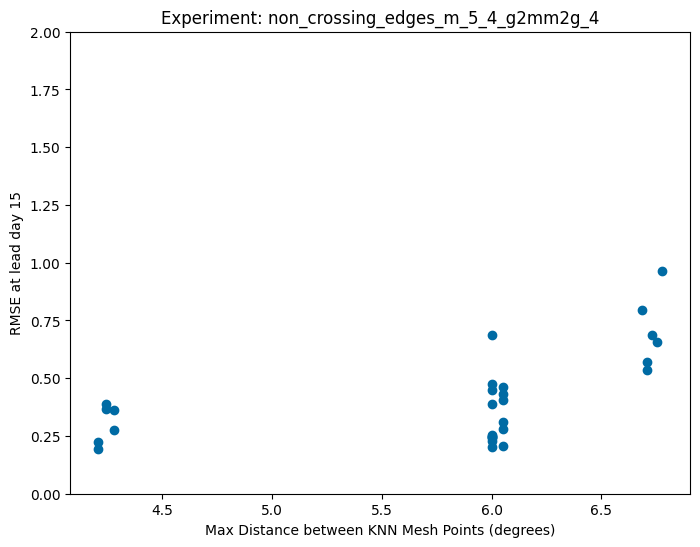

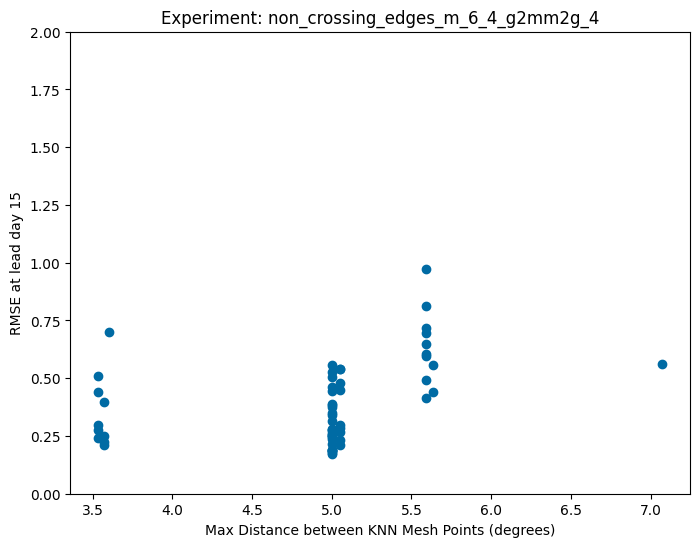

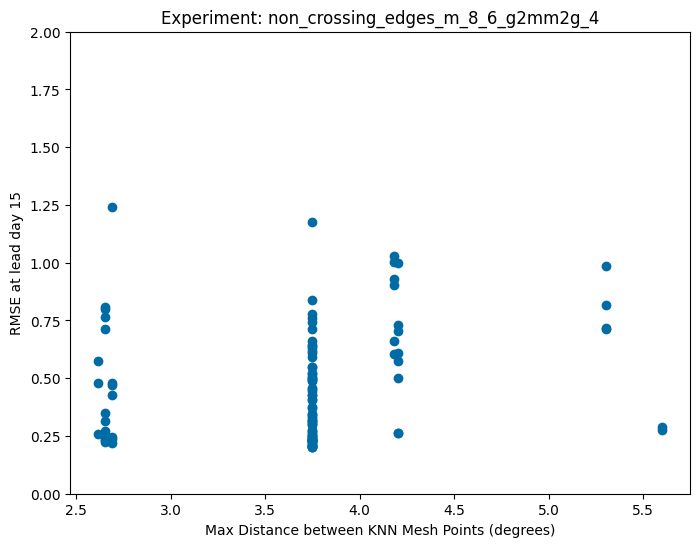

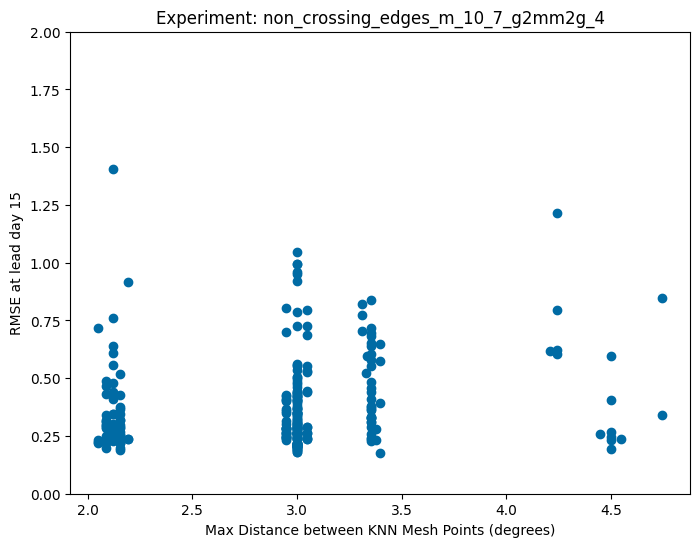

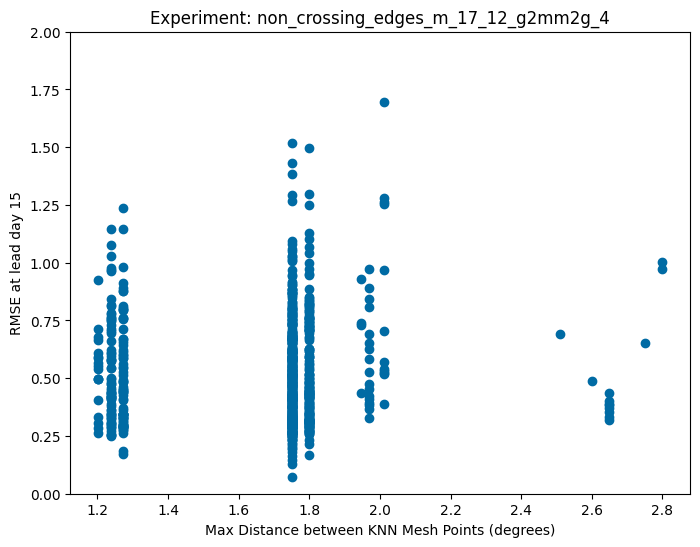

In [94]:
for exp in tqdm(experiments):
    mesh_lon = np.array(mesh_coords[exp.name])[0,:]
    mesh_lat = np.array(mesh_coords[exp.name])[1,:]
    tesela_map = k_voronoi_tesela_maps[exp.name]
    # Get tessela names (v_1^m, v_2^m, ...)
    tesselas = [tesela.value for tesela in tesela_map.keys()]
    y = [float(tesela.mean_rmse[-1]) for tesela in tesela_map.values()]
    x = []
    for t in tesselas:
        knn_mesh_coords = np.array(mesh_coords[exp.name])[:, t]
        pts = knn_mesh_coords.T  # (4, 2) -> cada fila es un punto (x, y)
        # Matriz de distancias por broadcasting
        D = np.sqrt(((pts[:, None, :] - pts[None, :, :])**2).sum(axis=-1))

        # Tomar solo el triángulo superior para evitar duplicados y la diagonal
        i, j = np.triu_indices(len(pts), k=1)
        k = np.argmax(D[i, j])

        max_dist = D[i[k], j[k]]
        x.append(float(max_dist))
        pair = (i[k], j[k])

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(x, y)
    ax.set_xlabel("Max Distance between KNN Mesh Points (degrees)")
    ax.set_ylabel("RMSE at lead day 15")
    ax.set_title(f"Experiment: {exp.name}")
    plt.ylim(0, 2)

In [15]:
area_to_point_map = defaultdict(dict)
for exp in tqdm(experiments):
    tesela_map = k_voronoi_tesela_maps[exp.name]
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            area_to_point_map[exp.name][(p.lon, p.lat)] = (
                tessela.area, p.value[-1]
                )

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
points_set = set()
for exp in experiments: 
    # Assign RMSE values to each cell point
    tesela_map = k_voronoi_tesela_maps[exp.name]
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            points_set.add((p.lon, p.lat))

print(f"unique grid points across all experiments: {len(points_set)}")

unique grid points across all experiments: 49061


In [34]:
all_areas = []
all_rmses = []

for p in list(points_set):
    area = [
        area_to_point_map[exp_name][p][0] 
        for exp_name in area_to_point_map.keys()
        ]
    rmse = [
        float(area_to_point_map[exp_name][p][1]) 
        for exp_name in area_to_point_map.keys()
        ]

    all_areas.extend(area)
    all_rmses.extend(rmse)

area_rmse = np.array(_remove_outliers(all_areas, all_rmses))
# Transformar X usando logaritmo base 10
X = np.log10(area_rmse[:, 0].reshape(-1, 1))
y = area_rmse[:, 1]

model = LinearRegression()
model.fit(X, y)

print("Modelo global con X en log₁₀:")
print(f"y = {model.coef_[0]:.4f} * log10(x) + {model.intercept_:.4f}")
print(f"R² = {model.score(X, y): .4f}")

Modelo global con X en log₁₀:
y = -0.0370 * log10(x) + 0.5814
R² =  0.0128


In [ ]:
# Suponiendo que ya tienes all_areas y all_rmses construidos

# Transformación log base 10
X_log = np.log10(area_rmse[:, 0].reshape(-1, 1))
y = area_rmse[:, 1]

# Generar características polinómicas: [x, x^2]
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_log)  # Esto genera columnas [x, x^2]

# Ajustar el modelo
model_quad = LinearRegression()
model_quad.fit(X_poly, y)

# Coeficientes
a = model_quad.coef_[1]   # x^2
b = model_quad.coef_[0]   # x
c = model_quad.intercept_

# R²
r2_quad = model_quad.score(X_poly, y)

print("Modelo cuadrático ajustado:")
print(f"y = {a:.6f} * (log10(x))^2 + {b:.6f} * log10(x) + {c:.6f}")
print(f"R² = {r2_quad:.4f}")

Modelo cuadrático ajustado:
y = 0.009884 * (log10(x))^2 + -0.118553 * log10(x) + 0.745405
R² = 0.0133


Text(0, 0.5, 'RMSE at lead day 15')

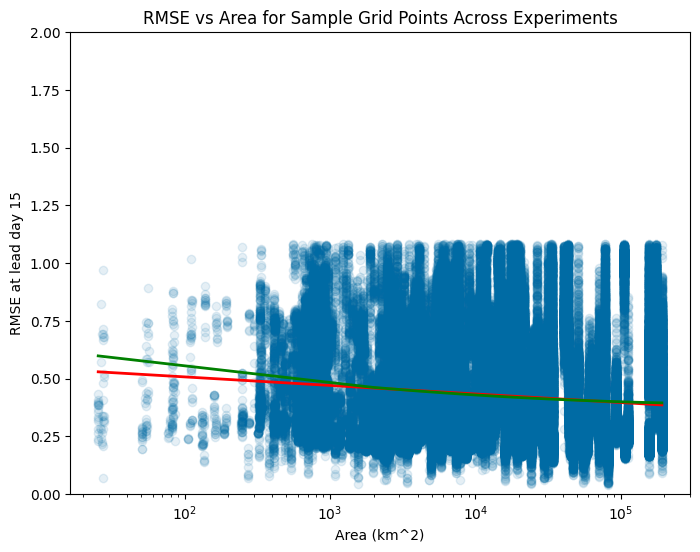

In [42]:
fig, ax = plt.subplots(figsize=(8,6))

# Linear model
x = np.linspace(min(area_rmse[:, 0]), max(area_rmse[:, 0]), 100)
y_linear = model.coef_[0] * np.log10(x) + model.intercept_
ax.plot(x, y_linear, color='red', label='Linear Fit', linewidth=2)
# Quadratic model
y_quad = a * (np.log10(x) ** 2) + b * np.log10(x) + c
ax.plot(x, y_quad, color='green', label='Quadratic Fit', linewidth=2)
ax.scatter(area_rmse[:, 0], area_rmse[:, 1], alpha=0.1)
ax.set_xlabel("Area (km^2)")
ax.set_ylabel("RMSE")
plt.xscale('log')
# set y limit
plt.ylim(0, 2)
ax.set_title("RMSE vs Area for Sample Grid Points Across Experiments")
ax.set_xlabel("Area (km^2)")
ax.set_ylabel("RMSE at lead day 15")

/tmp/ipykernel_3110853/2015883743.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


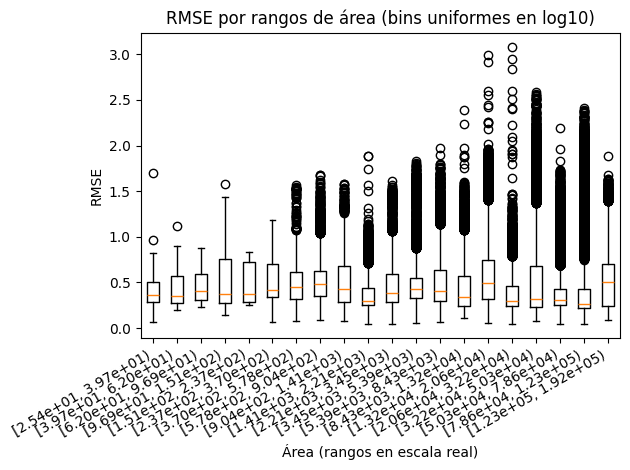

In [43]:
# 2) Transformar a log10 y definir bins (p.ej., 5 bins uniformes)
logA = np.log10(all_areas)
n_bins = 20
edges = np.linspace(logA.min(), logA.max(), n_bins + 1)

# 3) Asignar cada punto a un bin
bin_idx = np.digitize(logA, edges, right=False) - 1  # índices 0..n_bins-1

# 4) Preparar datos para el boxplot
data = []
labels = []
for i in range(n_bins):
    vals = np.array(all_rmses)[bin_idx == i]
    if len(vals) == 0:
        # Mantener el lugar con NaN para que el eje y etiquetas queden alineados
        data.append([])
    else:
        data.append(vals)
    # Etiquetas en escala real (no log), legibles:
    low = 10**edges[i]
    high = 10**edges[i+1]
    labels.append(f"[{low:.2e}, {high:.2e})")

# 5) Graficar
plt.boxplot(data, labels=labels, showfliers=True)
plt.xlabel("Área (rangos en escala real)")
plt.ylabel("RMSE")
plt.title("RMSE por rangos de área (bins uniformes en log10)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3110853/2013144726.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


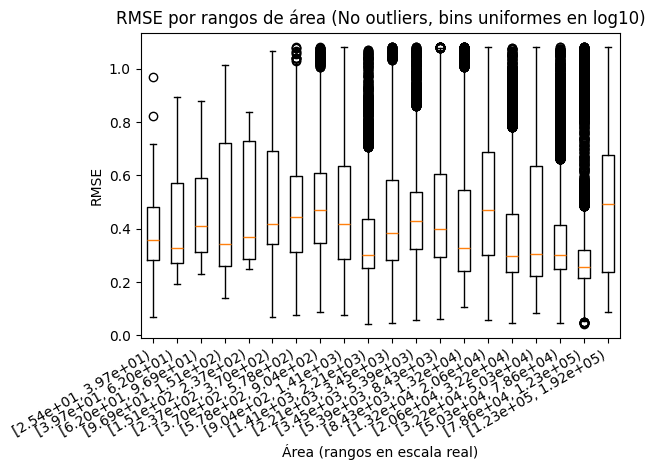

In [45]:
# 2) Transformar a log10 y definir bins (p.ej., 5 bins uniformes)
logA = np.log10(area_rmse[:, 0])
n_bins = 20
edges = np.linspace(logA.min(), logA.max(), n_bins + 1)

# 3) Asignar cada punto a un bin
bin_idx = np.digitize(logA, edges, right=False) - 1  # índices 0..n_bins-1

# 4) Preparar datos para el boxplot
data = []
labels = []
for i in range(n_bins):
    vals = np.array(area_rmse[:, 1])[bin_idx == i]
    if len(vals) == 0:
        # Mantener el lugar con NaN para que el eje y etiquetas queden alineados
        data.append([])
    else:
        data.append(vals)
    # Etiquetas en escala real (no log), legibles:
    low = 10**edges[i]
    high = 10**edges[i+1]
    labels.append(f"[{low:.2e}, {high:.2e})")

# 5) Graficar
plt.boxplot(data, labels=labels, showfliers=True)
plt.xlabel("Área (rangos en escala real)")
plt.ylabel("RMSE")
plt.title("RMSE por rangos de área (No outliers, bins uniformes en log10)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

:: Teselas found: 29
:: Teselas found: 59
:: Teselas found: 108
:: Teselas found: 266
:: Teselas found: 802


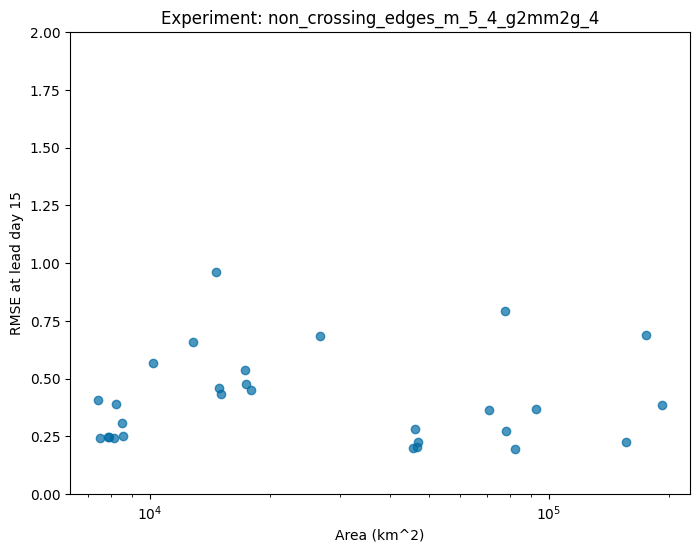

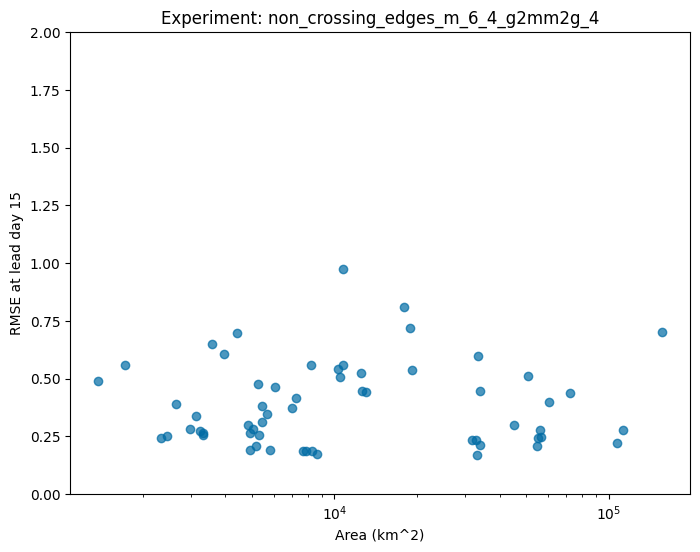

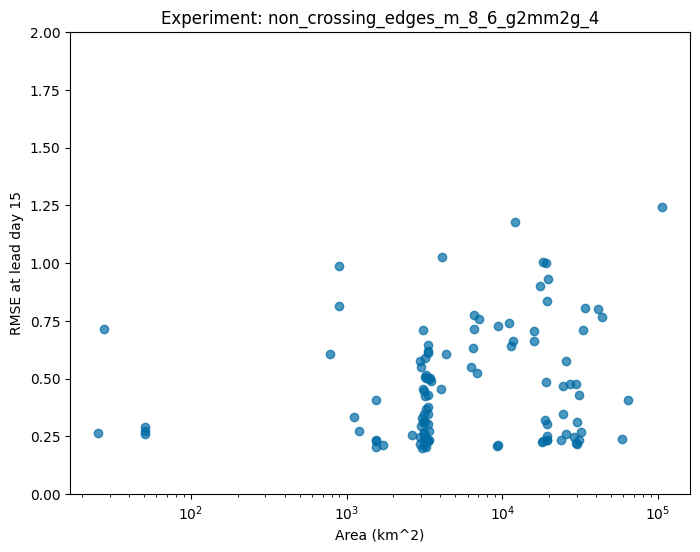

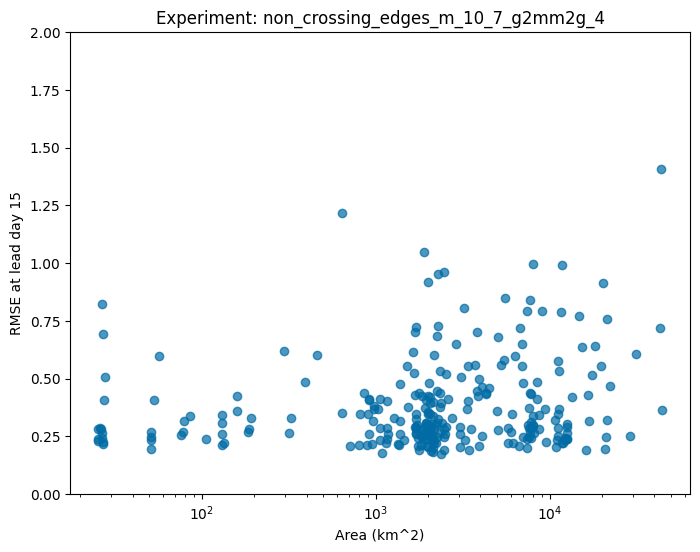

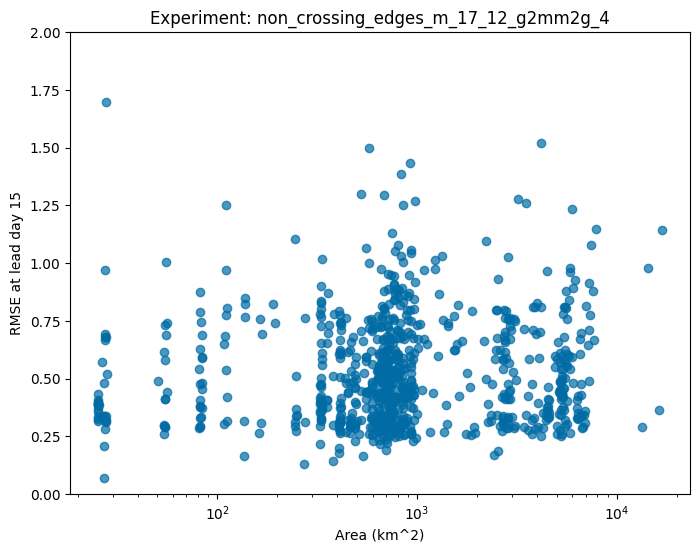

In [46]:
lead_days_idx = 14
              
for exp in tqdm(experiments):
    tesela_map = k_voronoi_tesela_maps[exp.name]

    print(f":: Teselas found: {len(tesela_map.keys())}")
    # print(":: Teselas:", tesela_map.keys())
    x = [tessela.area for tessela in tesela_map.values()]
    y = [tessela.mean_rmse[lead_days_idx] for tessela in tesela_map.values()]
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, alpha=0.7)
    # set y limit
    plt.ylim(0, 2)
    # x log scale
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel("Area (km^2)")
    plt.ylabel(f"RMSE at lead day {lead_days_idx+1}")
    plt.title(f"Experiment: {exp.name}")

  0%|          | 0/5 [00:00<?, ?it/s]

:: Teselas found: 29
:: Teselas found: 59
:: Teselas found: 108
:: Teselas found: 266
:: Teselas found: 802


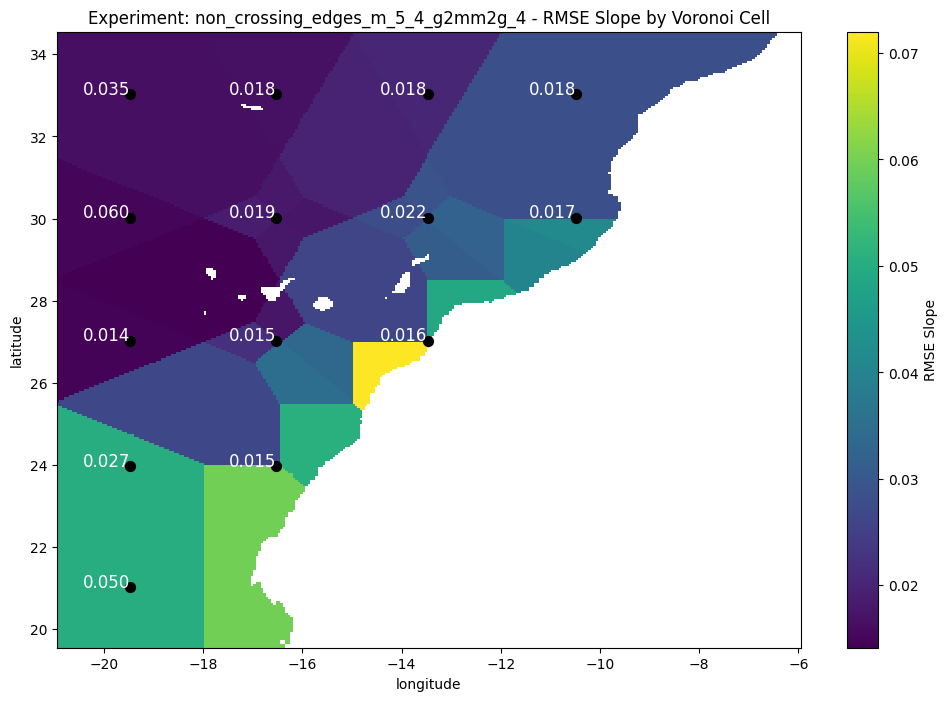

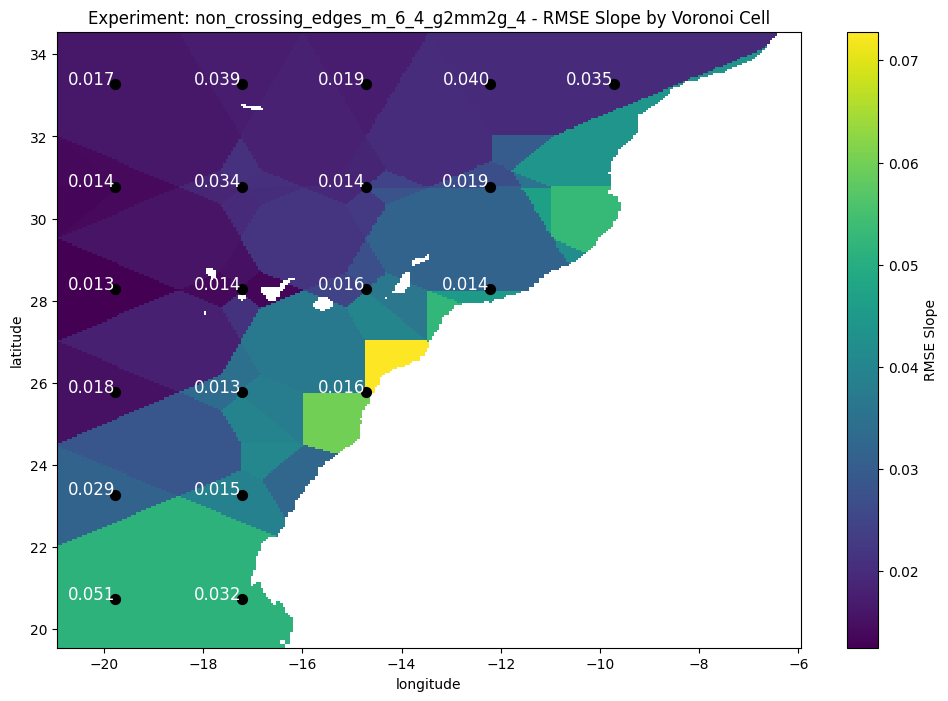

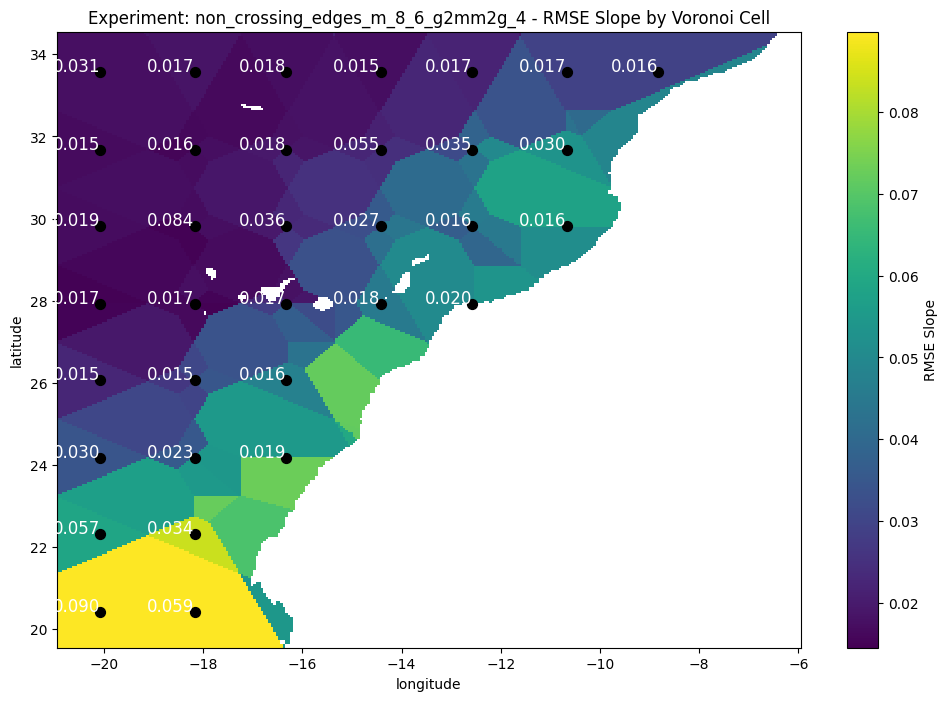

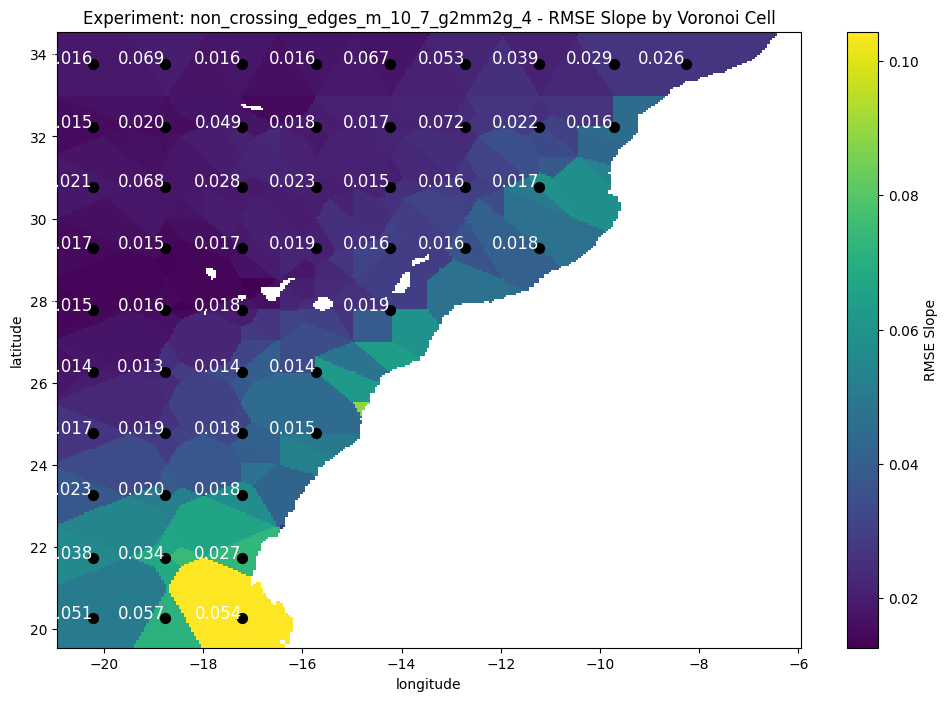

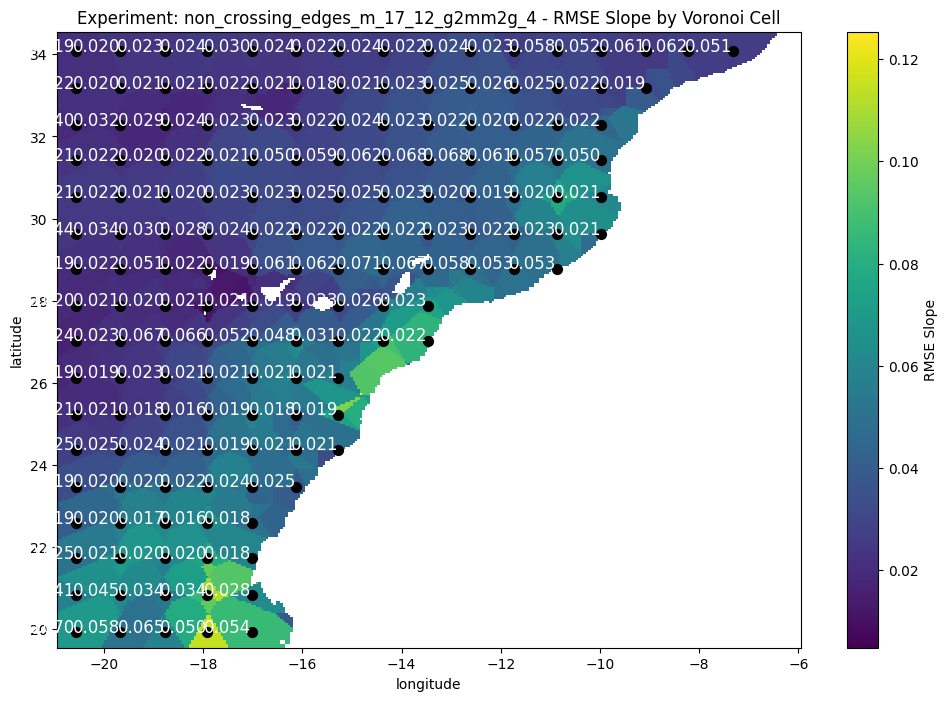

In [143]:
score = 'SquaredError'
var_name = 'sst_temperature'    
lead_days = [14]  # Example lead times to filter
for exp in tqdm(experiments): 
    with StatsAggSession(exp) as stats:
        data = filter_statistics(
            stats.agg_scores(['init_time']),
            dim_name='lead_time',
            filter_idx=lead_days,
            )[score][var_name].squeeze()

    tesela_map = k_voronoi_tesela_maps[exp.name]

    print(f":: Teselas found: {len(tesela_map.keys())}")
    # print(":: Teselas:", tesela_map.keys())
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            data.loc[dict(longitude=p.lon, latitude=p.lat)] = tessela.slope

    fig, ax = plt.subplots(figsize=(12, 8))
    data.plot.imshow(cmap='viridis', ax=ax, cbar_kwargs={'label': 'RMSE Slope'})
    ax.scatter(
        mesh_coords[exp.name][0], 
        mesh_coords[exp.name][1], 
        c='black', s=50, 
        label='Mesh Nodes'
        )
    # Add labels to the points
    for (slope, x, y) in zip(
        [tessela.slope for tessela in tesela_map.values()],
        mesh_coords[exp.name][0],
        mesh_coords[exp.name][1]
        ):
        ax.text(x, y, f"{slope:.3f}", fontsize=12, ha='right', color='white')
    ax.set_title(f"Experiment: {exp.name} - RMSE Slope by Voronoi Cell")

## Unstructured mesh: F-mesh
---

In [6]:
%%time
# number of nodes sequence for unstructured and structured meshes
unstructured_nodes = ["14_9", "20_9", "34_20", "52_27", "159_78"]
# mesh file names sequences
fps_mesh_names = [f"fps_m_{node}_g2mm2g_4" for node in unstructured_nodes]

# all experiment names
experiments_names = fps_mesh_names 
    
# load all experiments
experiments = [
    StatsLoader(os.path.join("~/Seacast/output/increase_n_nodes", exp_name)) 
    for exp_name in experiments_names
    ]
experiments

CPU times: user 66 μs, sys: 0 ns, total: 66 μs
Wall time: 72 μs


[ExpStats(name=fps_m_14_9_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/fps_m_14_9_g2mm2g_4/statistics),
 ExpStats(name=fps_m_20_9_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/fps_m_20_9_g2mm2g_4/statistics),
 ExpStats(name=fps_m_34_20_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/fps_m_34_20_g2mm2g_4/statistics),
 ExpStats(name=fps_m_52_27_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/fps_m_52_27_g2mm2g_4/statistics),
 ExpStats(name=fps_m_159_78_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/increase_n_nodes/fps_m_159_78_g2mm2g_4/statistics)]

In [7]:
%%time
# Get mesh coordinates for each experiment
mesh_coords = {}
for exp in experiments:
    mesh_levels = MeshLevels(
        exp.name, 
        exp.stats_dir, 
        'mesh_features.pt'
        )
    coords_grid = CoordGrid(exp)
    coords_mesh_exp = CoordMeshExp(exp, coords_grid, mesh_levels)
    mesh_coords[exp.name] = (coords_mesh_exp.lon, coords_mesh_exp.lat)

CPU times: user 49.7 s, sys: 57.5 s, total: 1min 47s
Wall time: 1min 47s


In [8]:
k_voronoi_tesela_maps = {}
for exp in experiments:
    mesh_nodes = mesh_coords[exp.name]
    k_voronoi_tesela_maps[exp.name] = get_k_domain(
        mesh_coords=(mesh_nodes[0], mesh_nodes[1]), 
        grid_coords=coords_grid,
        k=int(exp.name[-1])
        )

In [9]:
def make_empty_points_checker():
    empty_points_set = set()
    def check_empty(rmse_by_cell, p: CellPoint) -> set:
        nonlocal empty_points_set
        if np.isnan(rmse_by_cell).all():
            empty_points_set.add((p.lon, p.lat))
        return empty_points_set
    return check_empty

In [12]:
score = 'SquaredError'
var_name = 'sst_temperature'

for exp in tqdm(experiments): 
    with StatsAggSession(exp) as stats:
        data = stats.agg_scores(
            ['init_time']
            )[score][var_name].squeeze()

    tesela_map = k_voronoi_tesela_maps[exp.name]
    # Assign RMSE values to each cell point
    for tessela in tesela_map.values():
        # Create a checker for empty points
        check_empty = make_empty_points_checker()

        for p in tessela.grid_knn:
            rmse_by_cell = data.sel(
                longitude=p.lon, latitude=p.lat
                )
            empty_points = check_empty(rmse_by_cell, p)
            n_leads = rmse_by_cell.lead_time.size
            p.value = rmse_by_cell.data
        # Filter out empty points (tesselas partially over land)
        tessela.grid_knn = list(filter(not_empty_check, tessela.grid_knn))
        # Skip tesselas with no valid points (over land)
        if len(tessela.grid_knn) == 0:
            continue

        # Compute mean and std dev for each tessela    
        rmse_by_point = np.array([p.value for p in tessela.grid_knn])
        tessela.area = sum([p.area_km for p in tessela.grid_knn]) # km^2
        rmse_mean_by_tessela = np.nanmean(rmse_by_point, axis=0)
        rmse_std_by_tessela = np.nanstd(rmse_by_point, axis=0)

        # filter_nan_means = _remove_nans(rmse_mean_by_tessela)
        # filter_nan_stds = _remove_nans(rmse_std_by_tessela)
        if len(rmse_mean_by_tessela) != 0:
            tessela.mean_rmse = rmse_mean_by_tessela
            tessela.slope = get_slope(rmse_mean_by_tessela)
            tessela.std_rmse = rmse_std_by_tessela
        else:
            tessela.mean_rmse = np.repeat(np.nan, n_leads)
            tessela.slope = np.nan
            tessela.std_rmse = np.repeat(np.nan, n_leads)
    # Filter out tesselas with no valid points (over land)
    tesela_map = dict(filter(lambda item: len(item[1].grid_knn) > 0, tesela_map.items()))
    k_voronoi_tesela_maps[exp.name] = tesela_map

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
for p in list(points_set)[:1000]:
    area = [d[exp_name][p][0] for exp_name in d.keys()]
    rmse = [float(d[exp_name][p][1]) for exp_name in d.keys()]

    all_areas.extend(area)
    all_rmses.extend(rmse)

area_rmse = np.array(_remove_outliers(all_areas, all_rmses))
# Transformar X usando logaritmo base 10
X = np.log10(area_rmse[:, 0].reshape(-1, 1))
y = area_rmse[:, 1]

model = LinearRegression()
model.fit(X, y)

print("Modelo global con X en log₁₀:")
print(f"y = {model.coef_[0]:.4f} * log10(x) + {model.intercept_:.4f}")
print(f"R² = {model.score(X, y): .4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Modelo cuadrático ajustado:
y = -0.012719 * (log10(x))^2 + 0.164678 * log10(x) + -0.189492
R² = 0.0091
Modelo global con X:
y = 0.0050 * x + 0.2994
R² =  0.0011
Modelo cuadrático ajustado:
y = 0.029884 * (log10(x))^2 + -0.347414 * log10(x) + 1.500721
R² = 0.1026
Modelo global con X:
y = -0.0163 * x + 0.6236
R² =  0.0138
Modelo cuadrático ajustado:
y = 0.018773 * (log10(x))^2 + -0.245273 * log10(x) + 0.912908
R² = 0.2388
Modelo global con X:
y = -0.0726 * x + 0.5405
R² =  0.2089
Modelo cuadrático ajustado:
y = 0.029151 * (log10(x))^2 + -0.310513 * log10(x) + 0.931551
R² = 0.2063
Modelo global con X:
y = -0.0943 * x + 0.5636
R² =  0.1775
Modelo cuadrático ajustado:
y = 0.124323 * (log10(x))^2 + -0.729612 * log10(x) + 1.167014
R² = 0.3347
Modelo global con X:
y = -0.2457 * x + 0.7481
R² =  0.2888


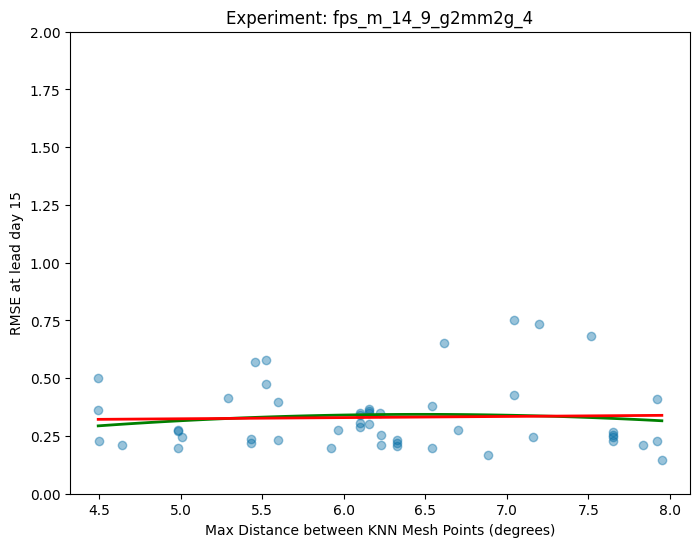

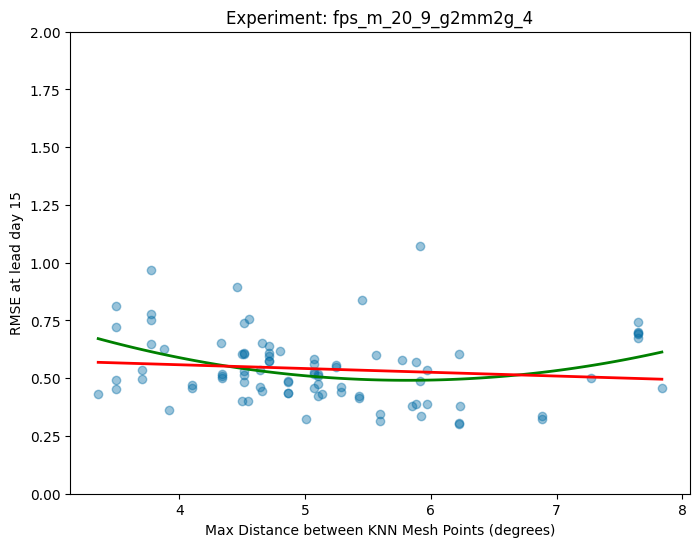

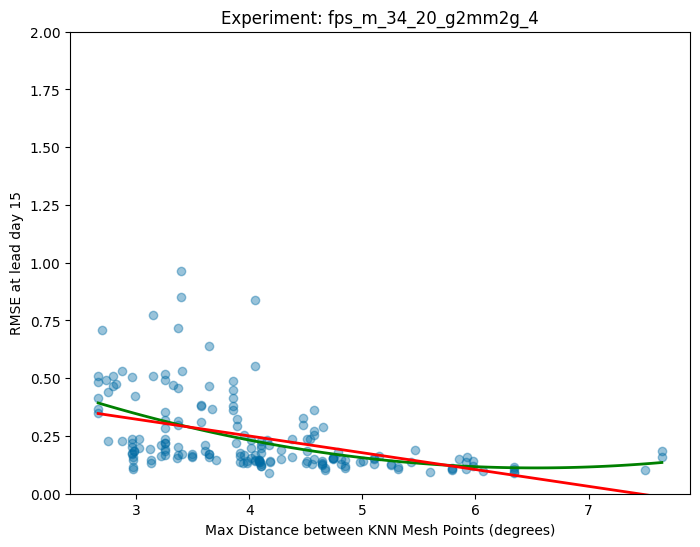

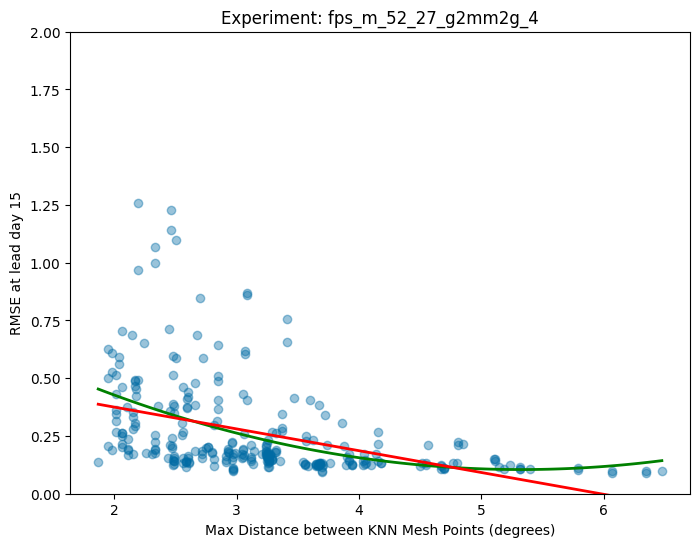

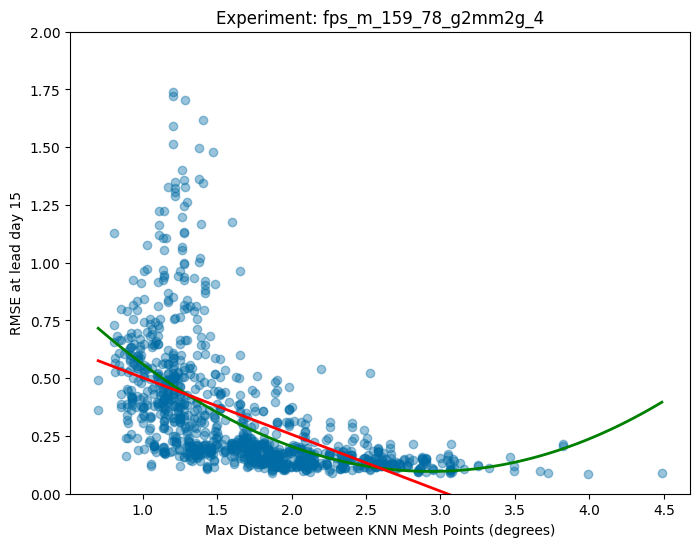

In [111]:
for exp in tqdm(experiments):
    mesh_lon = np.array(mesh_coords[exp.name])[0,:]
    mesh_lat = np.array(mesh_coords[exp.name])[1,:]
    tesela_map = k_voronoi_tesela_maps[exp.name]
    # Get tessela names (v_1^m, v_2^m, ...)
    tesselas = [tesela.value for tesela in tesela_map.keys()]
    y = [float(tesela.mean_rmse[-1]) for tesela in tesela_map.values()]
    x = []
    for t in tesselas:
        knn_mesh_coords = np.array(mesh_coords[exp.name])[:, t]
        pts = knn_mesh_coords.T  # (4, 2) -> cada fila es un punto (x, y)
        # Matriz de distancias por broadcasting
        D = np.sqrt(((pts[:, None, :] - pts[None, :, :])**2).sum(axis=-1))

        # Tomar solo el triángulo superior para evitar duplicados y la diagonal
        i, j = np.triu_indices(len(pts), k=1)
        k = np.argmax(D[i, j])

        max_dist = D[i[k], j[k]]
        x.append(float(max_dist))
        pair = (i[k], j[k])

    fig, ax = plt.subplots(figsize=(8,6))
    
    # Generar características polinómicas: [x, x^2]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(np.array(x).reshape(-1, 1))  # Esto genera columnas [x, x^2]
    # Ajustar el modelo
    model_quad = LinearRegression()
    model_quad.fit(X_poly, y)
    # Coeficientes
    a = model_quad.coef_[1]   # x^2
    b = model_quad.coef_[0]   # x
    c = model_quad.intercept_
    # R²
    r2_quad = model_quad.score(X_poly, y)
    print("Modelo cuadrático ajustado:")
    print(f"y = {a:.6f} * (log10(x))^2 + {b:.6f} * log10(x) + {c:.6f}")
    print(f"R² = {r2_quad:.4f}")
    # Quadratic model
    x_linear = np.linspace(min(x), max(x), 100)
    y_quad = a * (x_linear ** 2) + b * x_linear + c
    ax.plot(x_linear, y_quad, color='green', label='Quadratic Fit', linewidth=2)

    model = LinearRegression()
    model.fit(np.array(x).reshape(-1, 1), y)
    print("Modelo global con X:")
    print(f"y = {model.coef_[0]:.4f} * x + {model.intercept_:.4f}")
    print(f"R² = {model.score(np.array(x).reshape(-1, 1), y): .4f}")
    # Linear model
    y_linear = model.coef_[0] * x_linear + model.intercept_
    ax.plot(x_linear, y_linear, color='red', label='Linear Fit', linewidth=2)
    ax.scatter(x, y, alpha=0.4)
    ax.set_xlabel("Max Distance between KNN Mesh Points (degrees)")
    ax.set_ylabel("RMSE at lead day 15")
    ax.set_title(f"Experiment: {exp.name}")
    plt.ylim(0, 2)

  0%|          | 0/5 [00:00<?, ?it/s]

Modelo exponencial ajustado:
y ≈ 0.327966 * exp(-0.0118093 * x)   |   R² = -0.0335
Modelo cuadrático ajustado:
y = -0.012719 * (x)^2 + 0.164678 * x + -0.189492
R² = 0.0091
Modelo global con X:
y = 0.0050 * x + 0.2994
R² =  0.0011
Modelo exponencial ajustado:
y ≈ 0.629063 * exp(-0.036812 * x)   |   R² = -0.0001
Modelo cuadrático ajustado:
y = 0.029884 * (x)^2 + -0.347414 * x + 1.500721
R² = 0.1026
Modelo global con X:
y = -0.0163 * x + 0.6236
R² =  0.0138
Modelo exponencial ajustado:
y ≈ 0.674187 * exp(-0.289024 * x)   |   R² = 0.1822
Modelo cuadrático ajustado:
y = 0.018773 * (x)^2 + -0.245273 * x + 0.912908
R² = 0.2388
Modelo global con X:
y = -0.0726 * x + 0.5405
R² =  0.2089
Modelo exponencial ajustado:
y ≈ 0.641388 * exp(-0.345189 * x)   |   R² = 0.1416
Modelo cuadrático ajustado:
y = 0.029151 * (x)^2 + -0.310513 * x + 0.931551
R² = 0.2063
Modelo global con X:
y = -0.0943 * x + 0.5636
R² =  0.1775
Modelo exponencial ajustado:
y ≈ 0.959837 * exp(-0.772682 * x)   |   R² = 0.2695
Mode

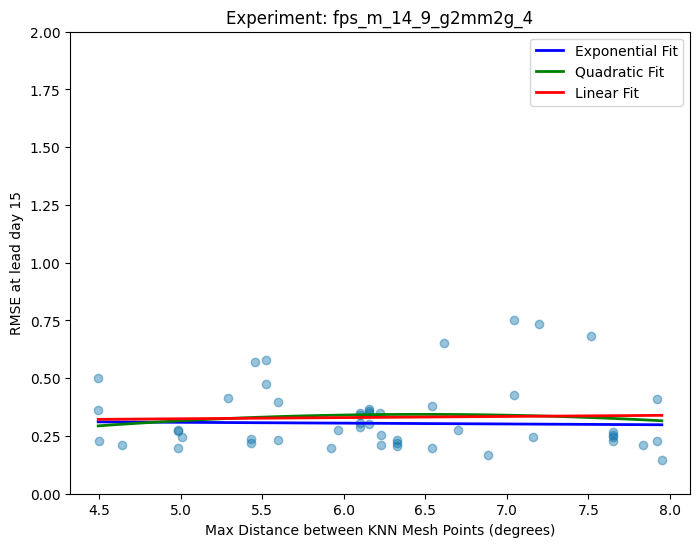

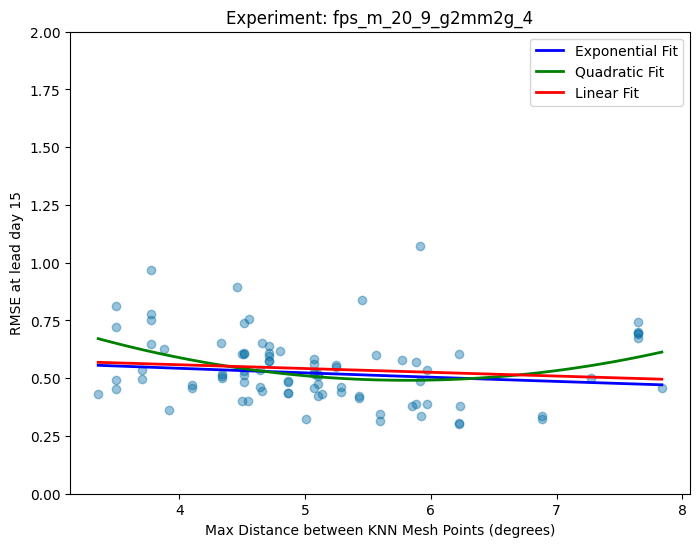

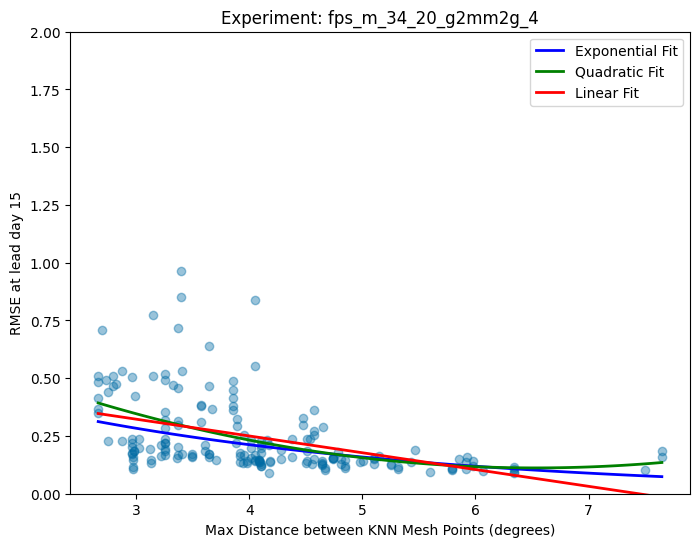

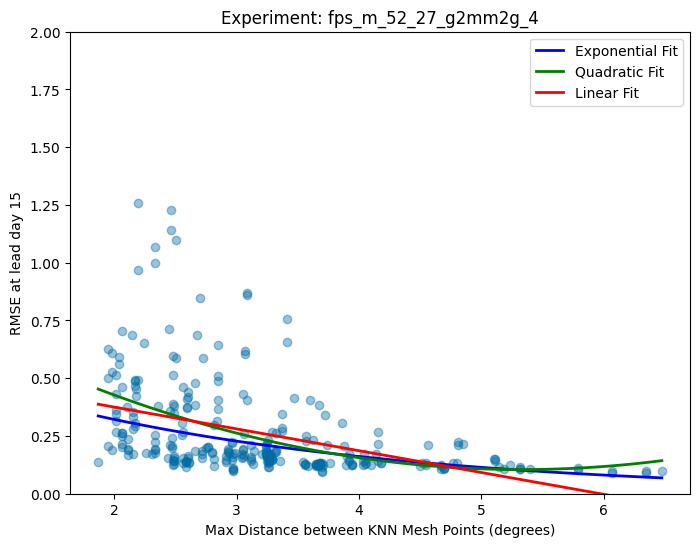

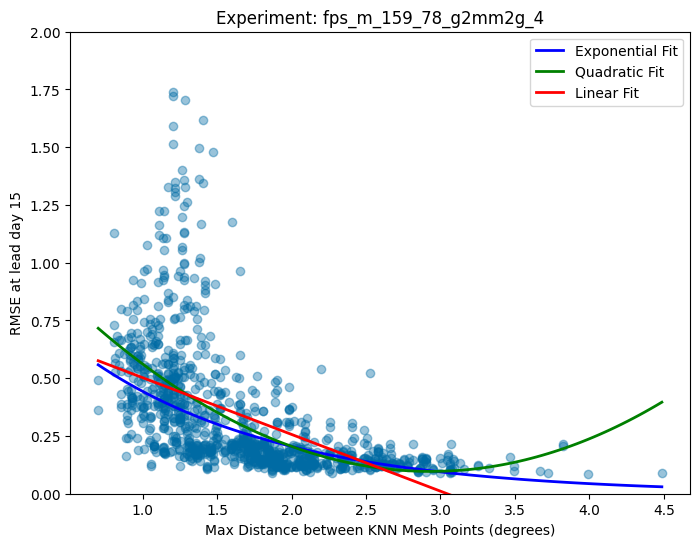

In [ ]:
for exp in tqdm(experiments):
    mesh_lon = np.array(mesh_coords[exp.name])[0,:]
    mesh_lat = np.array(mesh_coords[exp.name])[1,:]
    tesela_map = k_voronoi_tesela_maps[exp.name]
    # Get tessela names (v_1^m, v_2^m, ...)
    tesselas = [tesela.value for tesela in tesela_map.keys()]
    y = [float(tesela.mean_rmse[-1]) for tesela in tesela_map.values()]
    x = []
    for t in tesselas:
        knn_mesh_coords = np.array(mesh_coords[exp.name])[:, t]
        pts = knn_mesh_coords.T  # (4, 2) -> cada fila es un punto (x, y)
        # Matriz de distancias por broadcasting
        D = np.sqrt(((pts[:, None, :] - pts[None, :, :])**2).sum(axis=-1))

        # Tomar solo el triángulo superior para evitar duplicados y la diagonal
        i, j = np.triu_indices(len(pts), k=1)
        k = np.argmax(D[i, j])

        max_dist = D[i[k], j[k]]
        x.append(float(max_dist))
        pair = (i[k], j[k])

    fig, ax = plt.subplots(figsize=(8,6))
    x_linear = np.linspace(min(x), max(x), 100)

    # Exponential model
    from sklearn.compose import TransformedTargetRegressor
    reg = TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log,         # fit ln(y) = c0 + c1*x
        inverse_func=np.exp  # predict back in original space
    )
    reg.fit(np.array(x).reshape(-1, 1), y)
    # Parameters of y ≈ a * exp(b x)
    b = reg.regressor_.coef_[0]
    ln_a = reg.regressor_.intercept_
    a = np.exp(ln_a)>
    r2 = reg.score(np.array(x).reshape(-1, 1), y)
    print("Modelo exponencial ajustado:")
    print(f"y ≈ {a:.6g} * exp({b:.6g} * x)   |   R² = {r2:.4f}")
    y_exp = a * np.exp(b * x_linear)
    ax.plot(x_linear, y_exp, color='blue', label='Exponential Fit', linewidth=2)

    # Generar características polinómicas: [x, x^2]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(np.array(x).reshape(-1, 1))  # Esto genera columnas [x, x^2]
    # Ajustar el modelo
    model_quad = LinearRegression()
    model_quad.fit(X_poly, y)
    # Coeficientes
    a = model_quad.coef_[1]   # x^2
    b = model_quad.coef_[0]   # x
    c = model_quad.intercept_
    # R²
    r2_quad = model_quad.score(X_poly, y)
    print("Modelo cuadrático ajustado:")
    print(f"y = {a:.6f} * (x)^2 + {b:.6f} * x + {c:.6f}")
    print(f"R² = {r2_quad:.4f}")
    # Quadratic model
    y_quad = a * (x_linear ** 2) + b * x_linear + c
    ax.plot(x_linear, y_quad, color='green', label='Quadratic Fit', linewidth=2)

    model = LinearRegression()
    model.fit(np.array(x).reshape(-1, 1), y)
    print("Modelo global con X:")
    print(f"y = {model.coef_[0]:.4f} * x + {model.intercept_:.4f}")
    print(f"R² = {model.score(np.array(x).reshape(-1, 1), y): .4f}")
    # Linear model
    y_linear = model.coef_[0] * x_linear + model.intercept_
    ax.plot(x_linear, y_linear, color='red', label='Linear Fit', linewidth=2)
    ax.scatter(x, y, alpha=0.4)
    ax.set_xlabel("Max Distance between KNN Mesh Points (degrees)")
    ax.set_ylabel("RMSE at lead day 15")
    ax.set_title(f"Experiment: {exp.name}")
    plt.ylim(0, 2)
    plt.legend()

In [248]:
d = defaultdict(dict)
for exp in tqdm(experiments):
    tesela_map = k_voronoi_tesela_maps[exp.name]
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            d[exp.name][(p.lon, p.lat)] = (tessela.area, p.value[-1])

  0%|          | 0/5 [00:00<?, ?it/s]

In [249]:
points_set = set()
for exp in experiments: 
    # Assign RMSE values to each cell point
    tesela_map = k_voronoi_tesela_maps[exp.name]
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            points_set.add((p.lon, p.lat))

print(f"unique grid points across all experiments: {len(points_set)}")

unique grid points across all experiments: 49061


In [250]:
all_areas = []
all_rmses = []

for p in list(points_set)[:1000]:
    area = [d[exp_name][p][0] for exp_name in d.keys()]
    rmse = [float(d[exp_name][p][1]) for exp_name in d.keys()]

    all_areas.extend(area)
    all_rmses.extend(rmse)

area_rmse = np.array(_remove_outliers(all_areas, all_rmses))
# Transformar X usando logaritmo base 10
X = np.log10(area_rmse[:, 0].reshape(-1, 1))
y = area_rmse[:, 1]

model = LinearRegression()
model.fit(X, y)

print("Modelo global con X en log₁₀:")
print(f"y = {model.coef_[0]:.4f} * log10(x) + {model.intercept_:.4f}")
print(f"R² = {model.score(X, y): .4f}")

Modelo global con X en log₁₀:
y = 0.0568 * log10(x) + 0.0387
R² =  0.0415


In [251]:
from sklearn.preprocessing import PolynomialFeatures
# Suponiendo que ya tienes all_areas y all_rmses construidos

# Transformación log base 10
X_log = np.log10(area_rmse[:, 0].reshape(-1, 1))
y = area_rmse[:, 1]

# Generar características polinómicas: [x, x^2]
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_log)  # Esto genera columnas [x, x^2]

# Ajustar el modelo
model_quad = LinearRegression()
model_quad.fit(X_poly, y)

# Coeficientes
a = model_quad.coef_[1]   # x^2
b = model_quad.coef_[0]   # x
c = model_quad.intercept_

# R²
r2_quad = model_quad.score(X_poly, y)

print("Modelo cuadrático ajustado:")
print(f"y = {a:.6f} * (log10(x))^2 + {b:.6f} * log10(x) + {c:.6f}")
print(f"R² = {r2_quad:.4f}")

Modelo cuadrático ajustado:
y = 0.067763 * (log10(x))^2 + -0.483219 * log10(x) + 1.087524
R² = 0.0816


Text(0, 0.5, 'RMSE at lead day 15')

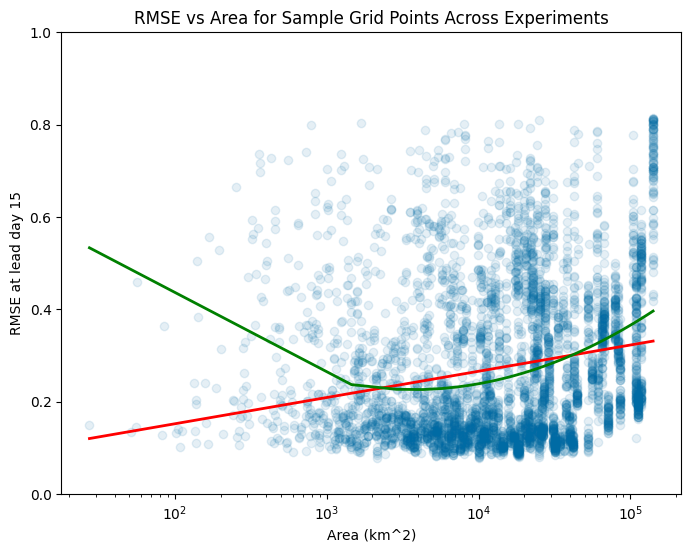

In [256]:
fig, ax = plt.subplots(figsize=(8,6))

# Linear model
x = np.linspace(min(area_rmse[:, 0]), max(area_rmse[:, 0]), 100)
y_linear = model.coef_[0] * np.log10(x) + model.intercept_
ax.plot(x, y_linear, color='red', label='Linear Fit', linewidth=2)
# Quadratic model
y_quad = a * (np.log10(x) ** 2) + b * np.log10(x) + c
ax.plot(x, y_quad, color='green', label='Quadratic Fit', linewidth=2)
# Plot data points
ax.scatter(area_rmse[:, 0], area_rmse[:, 1], alpha=0.1)
ax.set_xlabel("Area (km^2)")
ax.set_ylabel("RMSE")
plt.xscale('log')
# set y limit
plt.ylim(0, 1)
ax.set_title("RMSE vs Area for Sample Grid Points Across Experiments")
ax.set_xlabel("Area (km^2)")
ax.set_ylabel("RMSE at lead day 15")

  0%|          | 0/5 [00:00<?, ?it/s]

:: Teselas found: 50
:: Teselas found: 87
:: Teselas found: 178
:: Teselas found: 284
:: Teselas found: 1088


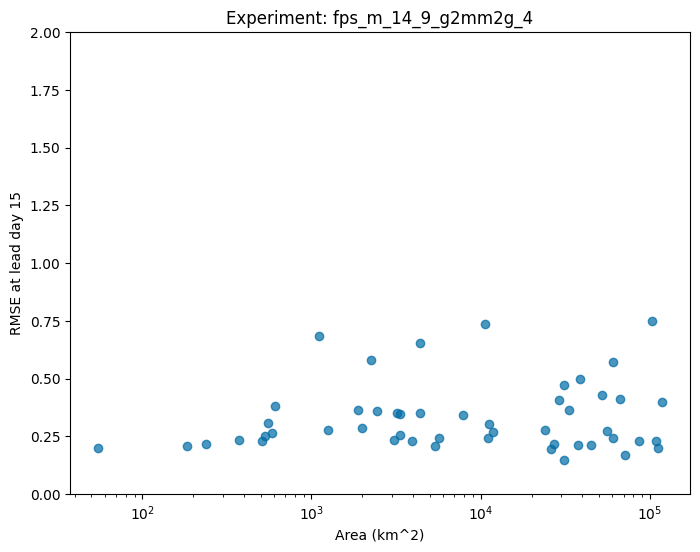

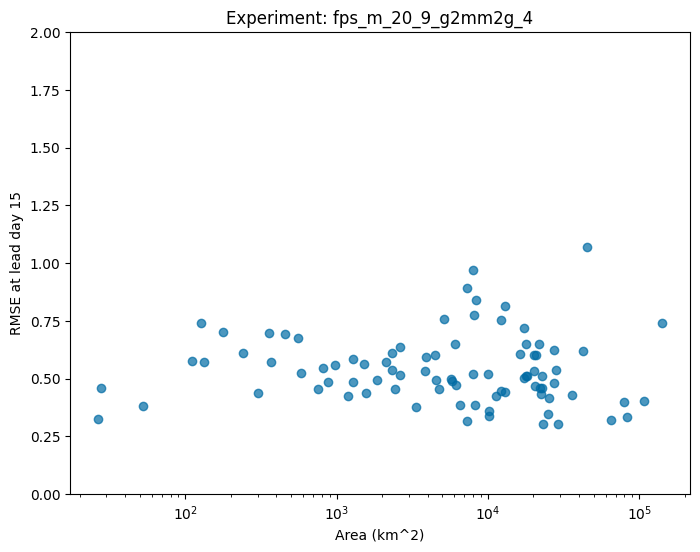

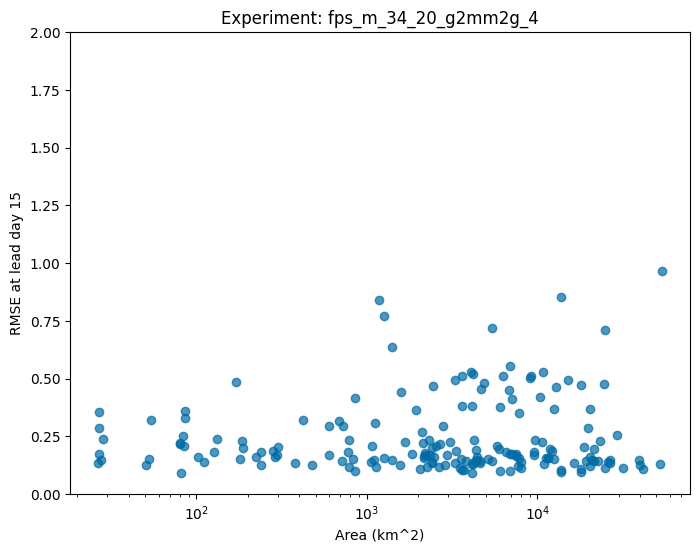

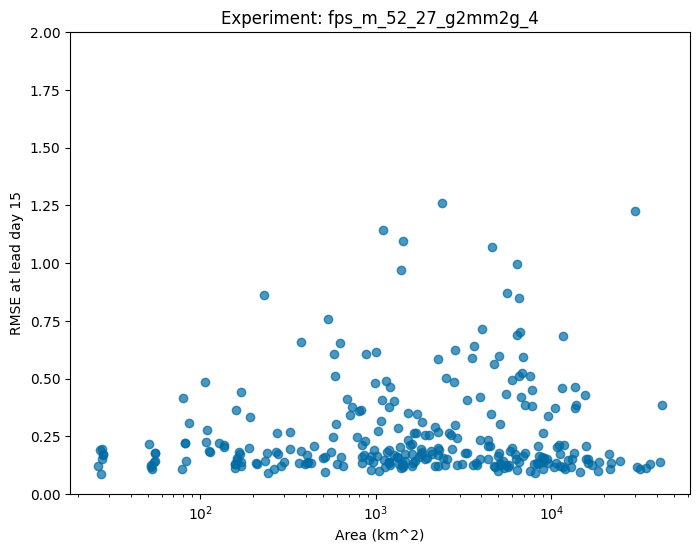

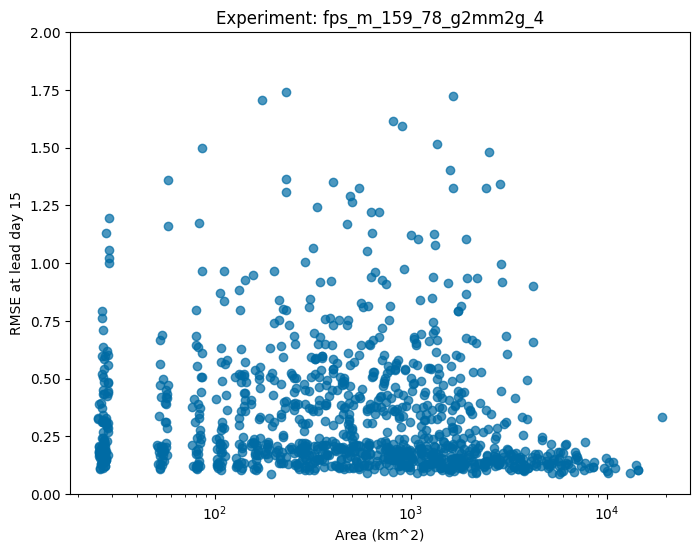

In [253]:
lead_days_idx = 14
              
for exp in tqdm(experiments):
    tesela_map = k_voronoi_tesela_maps[exp.name]

    print(f":: Teselas found: {len(tesela_map.keys())}")
    # print(":: Teselas:", tesela_map.keys())
    x = [tessela.area for tessela in tesela_map.values()]
    y = [tessela.mean_rmse[lead_days_idx] for tessela in tesela_map.values()]
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, alpha=0.7)
    # set y limit
    plt.ylim(0, 2)
    # x log scale
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel("Area (km^2)")
    plt.ylabel(f"RMSE at lead day {lead_days_idx+1}")
    plt.title(f"Experiment: {exp.name}")

  0%|          | 0/5 [00:00<?, ?it/s]

:: Teselas found: 50
:: Teselas found: 87
:: Teselas found: 178
:: Teselas found: 284
:: Teselas found: 1088


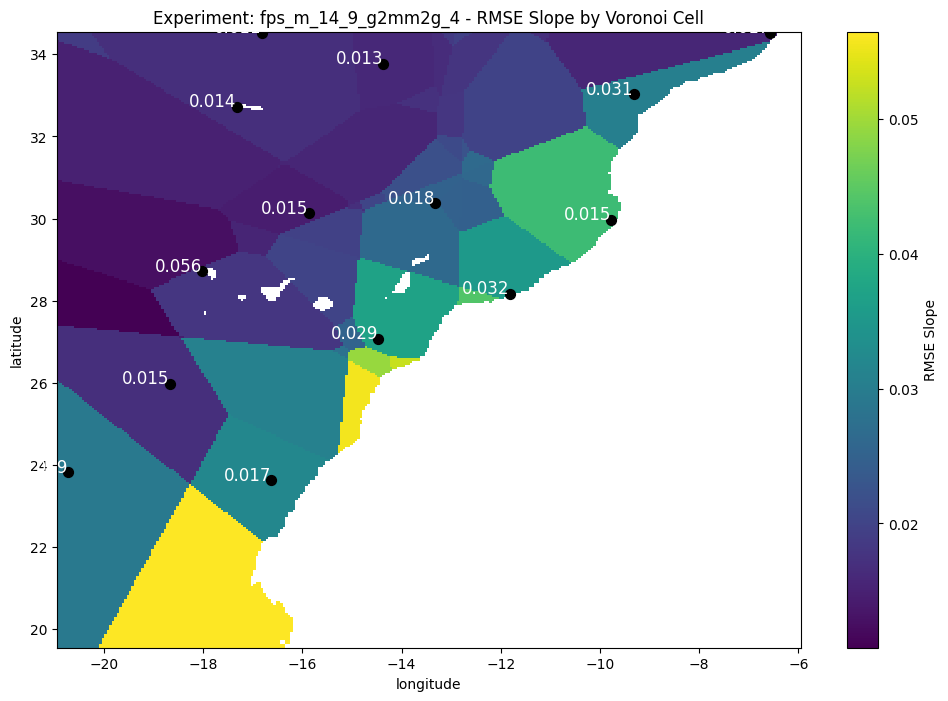

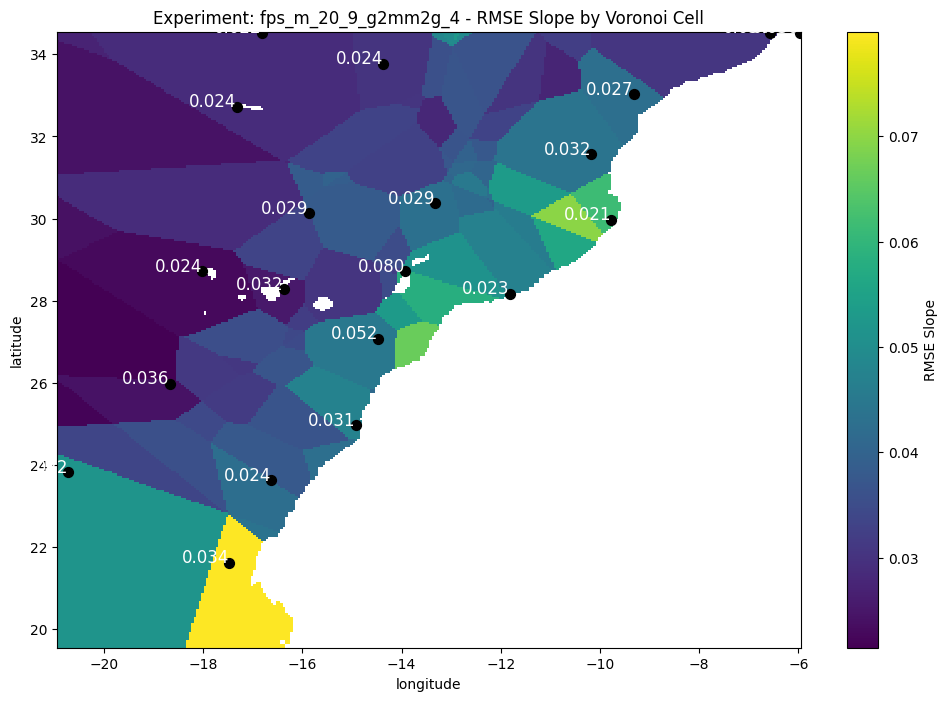

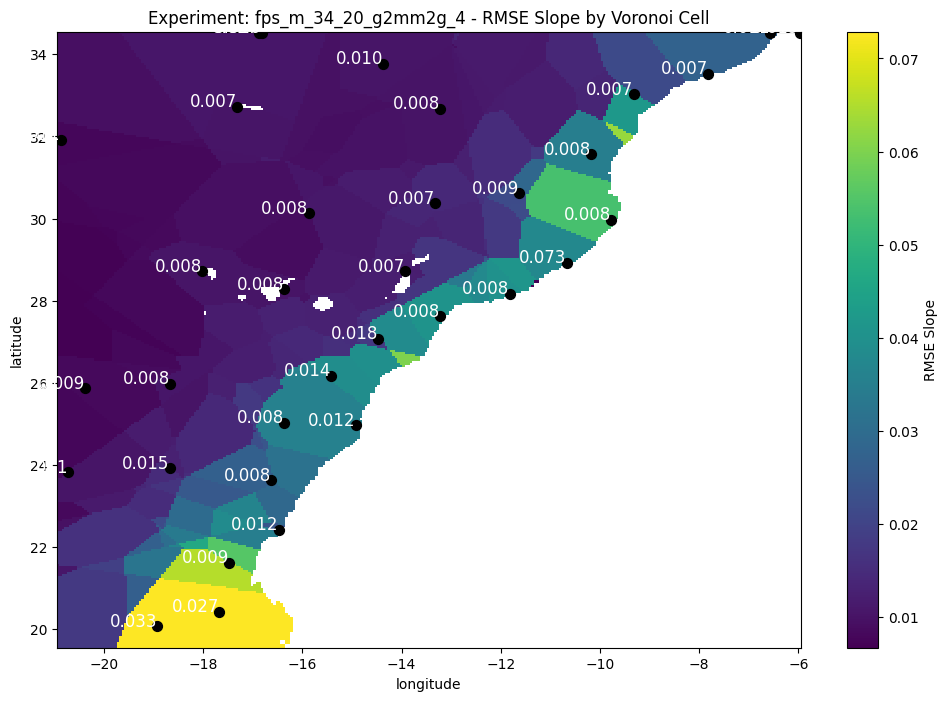

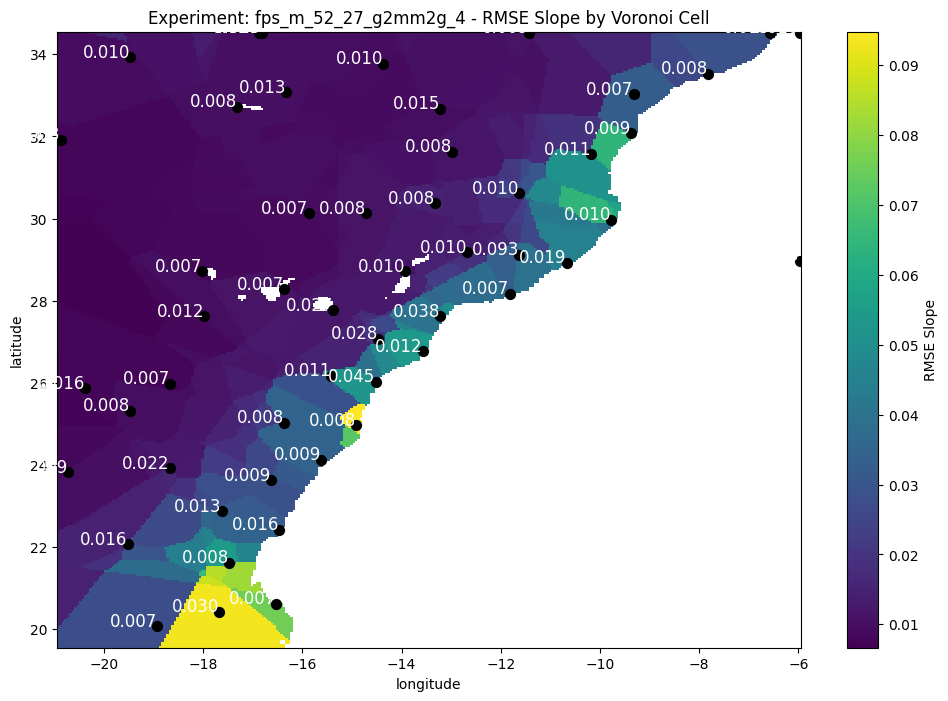

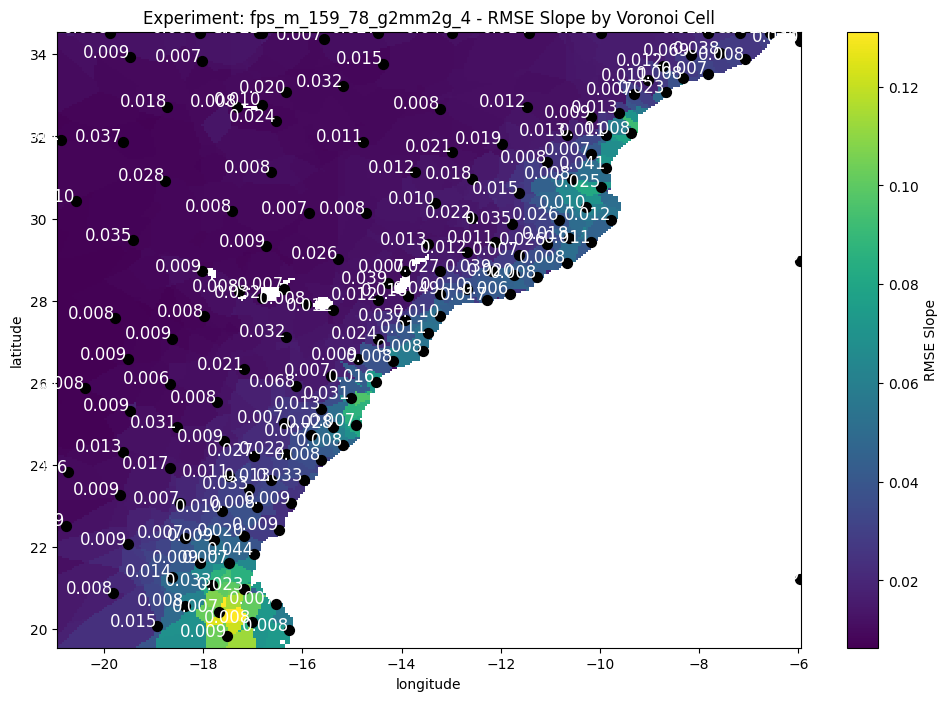

In [254]:
score = 'SquaredError'
var_name = 'sst_temperature'    
lead_days = [14]  # Example lead times to filter
for exp in tqdm(experiments): 
    with StatsAggSession(exp) as stats:
        data = filter_statistics(
            stats.agg_scores(['init_time']),
            dim_name='lead_time',
            filter_idx=lead_days,
            )[score][var_name].squeeze()

    tesela_map = k_voronoi_tesela_maps[exp.name]

    print(f":: Teselas found: {len(tesela_map.keys())}")
    # print(":: Teselas:", tesela_map.keys())
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            data.loc[dict(longitude=p.lon, latitude=p.lat)] = tessela.slope

    fig, ax = plt.subplots(figsize=(12, 8))
    data.plot.imshow(cmap='viridis', ax=ax, cbar_kwargs={'label': 'RMSE Slope'})
    ax.scatter(
        mesh_coords[exp.name][0], 
        mesh_coords[exp.name][1], 
        c='black', s=50, 
        label='Mesh Nodes'
        )
    # Add labels to the points
    for (slope, x, y) in zip(
        [tessela.slope for tessela in tesela_map.values()],
        mesh_coords[exp.name][0],
        mesh_coords[exp.name][1]
        ):
        ax.text(x, y, f"{slope:.3f}", fontsize=12, ha='right', color='white')
    ax.set_title(f"Experiment: {exp.name} - RMSE Slope by Voronoi Cell")

  0%|          | 0/5 [00:00<?, ?it/s]

:: Teselas found: 50
:: Teselas found: 87
:: Teselas found: 178
:: Teselas found: 284
:: Teselas found: 1088


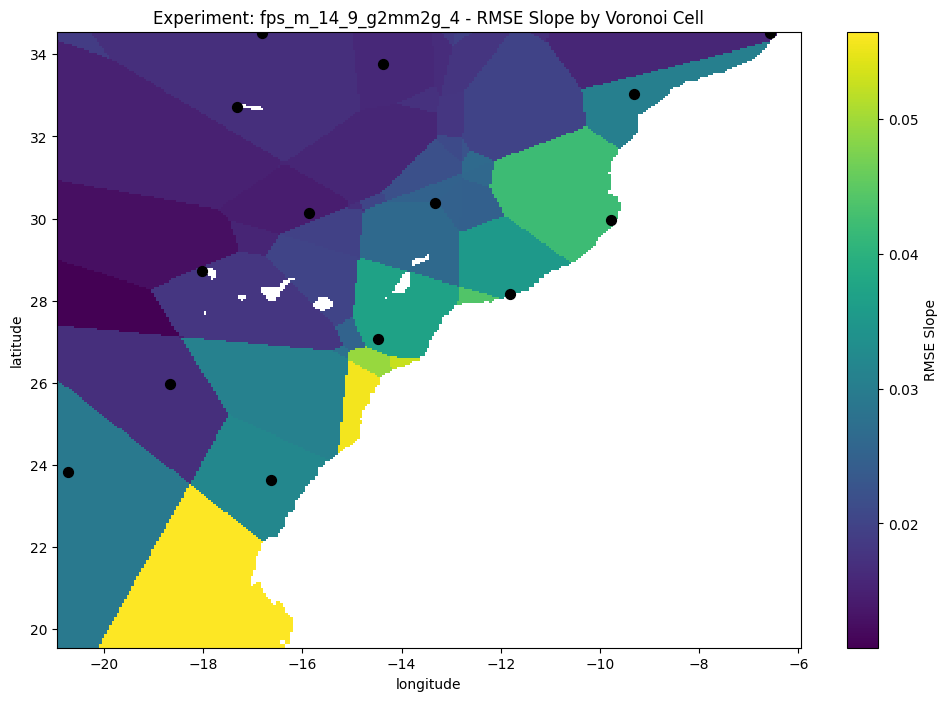

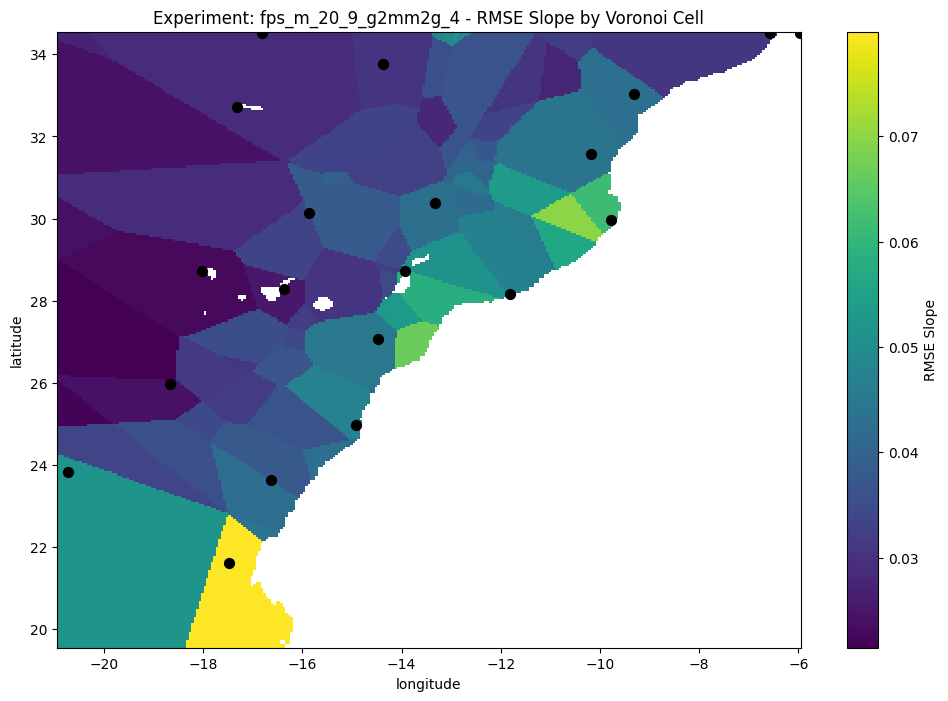

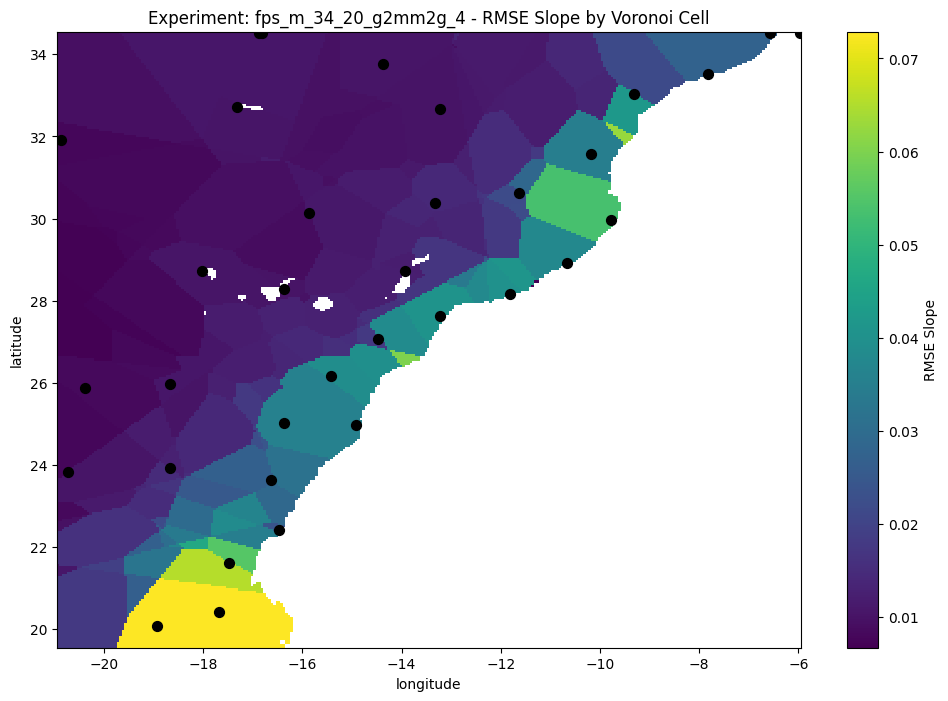

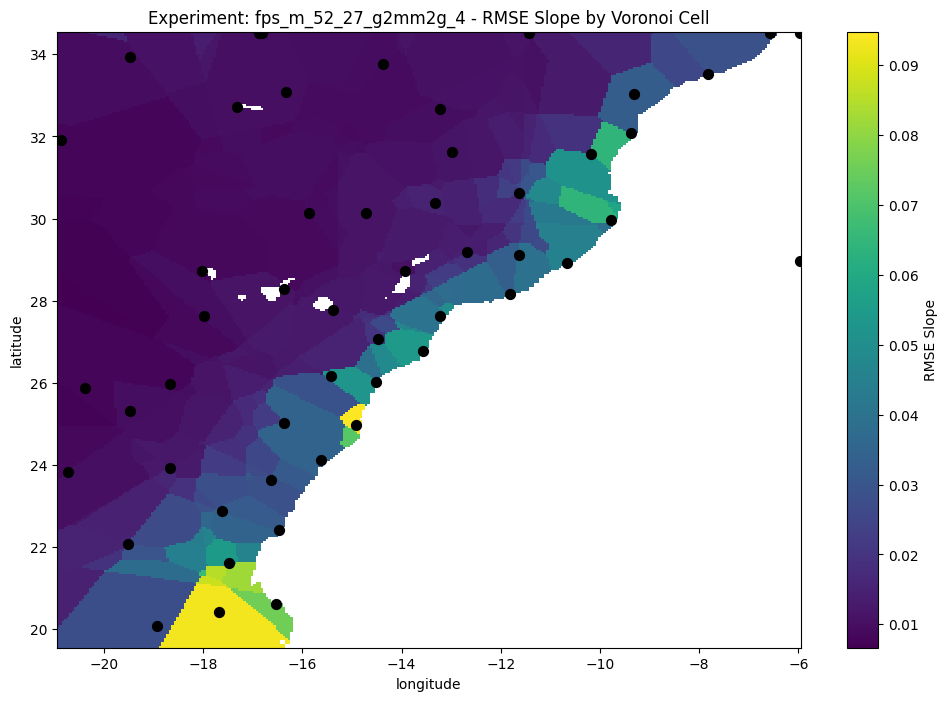

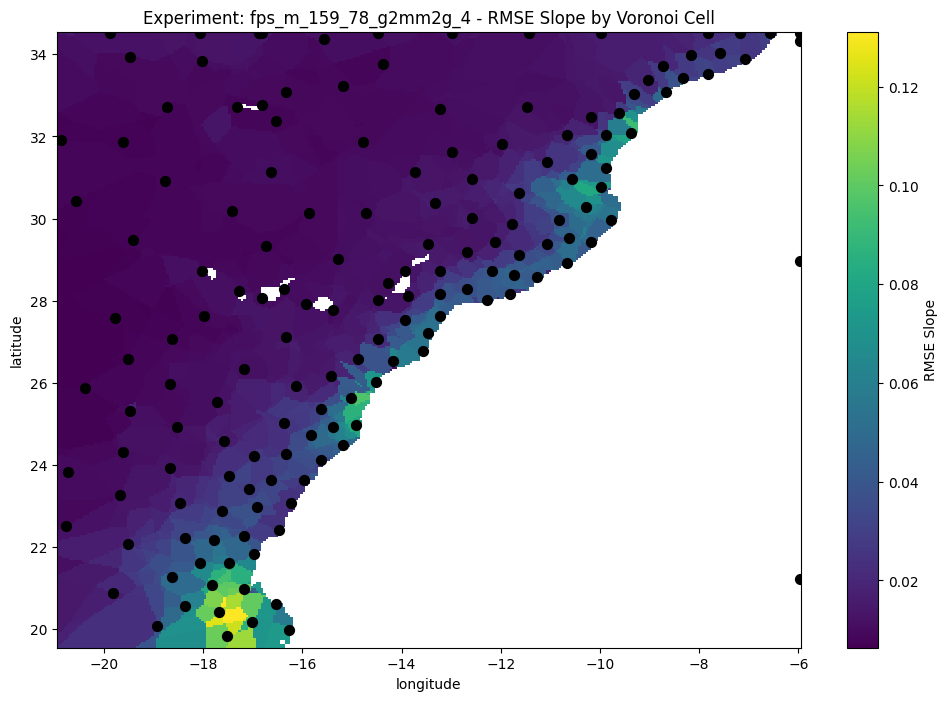

In [21]:
score = 'SquaredError'
var_name = 'sst_temperature'    
lead_days = [14]  # Example lead times to filter
for exp in tqdm(experiments): 
    with StatsAggSession(exp) as stats:
        data = filter_statistics(
            stats.agg_scores(['init_time']),
            dim_name='lead_time',
            filter_idx=lead_days,
            )[score][var_name].squeeze()

    tesela_map = k_voronoi_tesela_maps[exp.name]

    print(f":: Teselas found: {len(tesela_map.keys())}")
    # print(":: Teselas:", tesela_map.keys())
    for tessela in tesela_map.values():
        for p in tessela.grid_knn:
            data.loc[dict(longitude=p.lon, latitude=p.lat)] = tessela.slope

    fig, ax = plt.subplots(figsize=(12, 8))
    data.plot.imshow(cmap='viridis', ax=ax, cbar_kwargs={'label': 'RMSE Slope'})
    ax.scatter(
        mesh_coords[exp.name][0], 
        mesh_coords[exp.name][1], 
        c='black', s=50, 
        label='Mesh Nodes'
        )
    # Add labels to the points
    ax.set_title(f"Experiment: {exp.name} - RMSE Slope by Voronoi Cell")